# **Introduction**

In the current digital landscape, grasping how customers engage with online advertisements is crucial for developing effective marketing strategies. This project aims to create a predictive model that assesses the probability of customers clicking on ads. The primary goal is to analyze historical ad click data to identify patterns and trends that can help businesses tailor their advertising efforts and improve engagement rates.

To achieve this, we will utilize several modeling techniques, including logistic regression, decision trees, random forest, and XGBoost. These models are chosen for their ability to handle complex relationships and interactions within the data, especially given the imbalanced nature of ad click datasets. We expect that by applying these models, we can accurately predict which users are more likely to click on ads, thereby enhancing the effectiveness of advertising campaigns.

Our hypotheses include the belief that certain features, such as cursor postion (X & Y), ad placement and type of ads, will significantly influence click-through rates. We anticipate that the XGBoost model will outperform the others due to its robustness in handling non-linear relationships and interactions among variables.

The importance of this study cannot be overstated. As businesses increasingly rely on digital marketing, having a reliable predictive model can lead to more efficient budget allocation, targeted advertising campaigns, and ultimately, higher conversion rates. By understanding customer behavior better, companies can create personalized ad experiences that resonate with their audience, maximizing their return on investment. Through comprehensive analysis and model testing, this study offers valuable insights into user interactions with advertisements. It demonstrates how data-driven approaches can enhance marketing effectiveness and contribute to better decision-making in the digital advertising industry.


## Purpose & Scope

The primary objective of this project is to prepare and model data to accurately predict ad clicks. This involves several key steps:

*    **Data Cleaning:** Identifying and rectifying any errors or inconsistencies in the data to ensure its quality.

*   **Data Transformation:** Converting the data into a suitable format for analysis, including normalization and encoding of categorical variables.

*   **Model Selection and Training:** Choosing appropriate modeling techniques, such as logistic regression or decision trees, and training the model on the prepared data.

*   **Model Evaluation:** Assessing the model’s performance using metrics like accuracy, precision, and recall to ensure its reliability.

## Significance

Predicting ad clicks is crucial for maximizing the return on investment in digital marketing. A reliable predictive model enables businesses to better understand their audience, tailor their advertisements to meet customer preferences, and allocate marketing budgets more efficiently. This leads to more effective marketing campaigns, higher engagement rates, and ultimately, increased revenue.

## Summary of findings

Overall, the model with the best performance was XG-Boost 1 which used data set that was only oversampled and it hyperparameters were:
- Gamma = 0.2
- Learning Rate = 0.01
- Number of Estimators = 100
- Sub Sample = 0.7
- Maximum Depth = 8
- COl Sample = 0.8

The result on the validation data provided F1 score of 50% of the minority with 74% accuracy even though I was not focusing on it.

For more details, please visit the [Model Interpretation & Selection](#model-interpretation--selection) section.


# Data Preparation

## Dataframes Description

This time before starting the data preparation, I will just give information on my data frames. This is becuse it might get confusing because I will be preparing different data frames for different visualisation and also for modelling. The information below on the dataframes hopefully will make it easier to understand. The df that is in brackets is just copy of respective dataframe because it just reassures me that if anything goes wrong I have a backup copy.

**Dataframes Description**
- **Clean_df** = This df has merged data of groundtruth and participant file. (clean_df_copy)

- **log_df** = This df contains all the data from all log files into one df. (log_df_copy)

- **PGL_agg_df** = This df contains combined data from all three files in an aggregated manner without handling outliers. PGL stands for participant, groundtruth & Log_data. (PGL_agg_df_copy)

- **PGL_agg_df2** = This df contains combined data from all three files in an aggregated manner but with top 6 total time column removed while sorted in descending order because the difference was significant. (PGL_agg_copy_df)

- **PGL_agg_WO_df** = This df contains combined data from all three files but the outliers are handled and they are capped at upper and lower bound using total_time column. (PGL_agg_WO_copy_df)

- **log_static_df** = The data from all files are combined here. All log data is present equalling of 106000 rows but static features are only concatenated once per log_id. (log_static_copy_df)

- **model_df** = This data will be used for modelling where age, education, gender, column have been removed and only first 5 seconds of log data has been used in an aggregated manner. (model_df_copy)

## Loading Data

In [ ]:
# Import necessary packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, randint
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline


Below, I will show how I access my data. I will mount the drive and access the copy of my data that is located in the drive.

In [ ]:
# Import method 1: in Colab, mount Drive and then use Pandas
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import method 1 cont'd: read in the data
gdf = pd.read_csv("/content/drive/MyDrive/Classification data files/groundtruth.csv", sep=',')
pdf = pd.read_csv("/content/drive/MyDrive/Classification data files/participants.csv", sep=',')

print("Ground Truth File Data")
display(gdf.head())

print('')
print('')
print("Participant File Data")
display(pdf.head())

Ground Truth File Data


,user_id,ad_clicked,attention,log_id
0,5npsk114ba8hfbj4jr3lt8jhf5,0,4,20181002033126
1,5o9js8slc8rg2a8mo5p3r93qm0,1,5,20181001211223
2,pi17qjfqmnhpsiahbumcsdq0r6,0,4,20181001170952
3,3rptg9g7l83imkbdsu2miignv7,0,1,20181001140754
4,049onniafv6fe4e6q42k6nq1n2,0,1,20181001132434




Participant File Data


,user_id,country,education,age,income,gender,ad_position,ad_type,ad_category,serp_id,query,log_id
0,5npsk114ba8hfbj4jr3lt8jhf5,PHL,3,3,1,male,top-left,dd,Computers & Electronics,tablets,tablets,20181002033126
1,5o9js8slc8rg2a8mo5p3r93qm0,VEN,3,1,1,male,top-right,dd,Shop - Luxury Goods,casio-watches,casio watches,20181001211223
2,pi17qjfqmnhpsiahbumcsdq0r6,VEN,2,3,1,male,top-left,native,Shop - Luxury Goods,chivas-regal,chivas regal,20181001170952
3,3rptg9g7l83imkbdsu2miignv7,VEN,3,2,1,male,top-right,dd,Shop - Luxury Goods,chivas-regal,chivas regal,20181001140754
4,049onniafv6fe4e6q42k6nq1n2,VEN,3,5,1,male,top-left,native,Autos & Vehicles,audi-r8-used,audi r8 used,20181001132434


I will make sure that numbers are displayed well and not in scientific notation.

In [ ]:
pd.set_option('display.float_format', '{:.3f}'.format)

## Cleaning Data

### Striping whitespaces from column names

The project is already long so I will not show why this step is requiired however during my drafting most of the column names had whitespace. Stripping whitespace from column names ensures consistency in naming and avoids potential issues when merging or accessing columns.

In [ ]:
#striping the whitespace
pdf.columns = pdf.columns.str.strip()
gdf.columns = gdf.columns.str.strip()

### Unique & Same user_id Confirmation

I will also check that the user_ids in groundtruth and participant data is unique and same in both.

In [ ]:
#checks if the user_id in both dataframe is same
if gdf['user_id'].equals(pdf['user_id']):
  print('True')
else:
  print('False')

True


As it can be seen above that it returned true that means user_ids both in groundtruth and particpant file is same.

In [ ]:
#confirms that all user_ids are unique in both files
print(f"Number of rows in groundtruth file : {len(pdf)}")
print(f'Number or unique user_id in groundtruth file : {len(gdf["user_id"].unique())}')
print()
print(f"Number of rows in participant file : {len(pdf)}")
print(f'Number or unique user_id in participant file : {len(pdf["user_id"].unique())}')

Number of rows in groundtruth file : 2909
Number or unique user_id in groundtruth file : 2909

Number of rows in participant file : 2909
Number or unique user_id in participant file : 2909


As it can be seen above that len of unique user_ids in both files is same as len of df. This proves that all rows have unique user_ids.

## Dataframes creation

### Clean_df

This data frame has merged data from groundtruth and participant file.

In [ ]:
clean_df = pdf.merge(gdf, on = 'user_id', how='left')
clean_df = clean_df.drop('log_id_y', axis=1)

#### Converting columns to numeric & filling missing income values

- The specified columns are converted to numeric types. Using errors='coerce' ensures that any non-numeric values are replaced with NaN.
- The median income value is then used to fill in missing income values.
- This approach is suitable for this specific dataset, as income data is typically missing in small proportions and the median value provides a reasonable estimate of the missing values.
- Also, this method of imputation is robust against outliers and helps maintain the dataset's integrity.

In [ ]:
#Converting and filling
#tried to replace any commas with decimals so it does not mess with the coerce function
clean_df[['education', 'age', 'income']] = clean_df[['education', 'age', 'income']].replace({',': '.'}, regex=True)
clean_df[['education','age','income']] = clean_df[['education','age','income']].apply(pd.to_numeric, errors='coerce')
median_value = clean_df['income'].median()
clean_df['income'] = clean_df['income'].fillna(median_value)

#### Creat a clean copy of data frame

- A copy of the clean DataFrame is made to preserve the original data.

- The dropna() function is then used to remove age and education rows with NaN values, ensuring the clean DataFrame only contains complete cases for analysis.

- I removed the age and education rows because the numbers of rows that have missing values are less than 5% which is insignificant for our analysis.

In [ ]:
#copying and dropping
clean_df_copy = clean_df.copy()
clean_df = clean_df.dropna()

####  One-hot encoding, & dropping columns

- This step separates the country values by categorizing all non-USA entries as 'non-USA'. This simplification can help in analysis and visualization.
- Using pd.get_dummies() transforms categorical variables into a one-hot encoded format, which is necessary for our machine learning algorithms that require numerical input.  
- I have removed the columns that was increasing multicoliniarity and also to match the sample file I received in which the data was already prepared for me.
- Removing columns that are not needed for analysis reduces the dimensionality of the DataFrame and focuses on relevant features, improving efficiency.


In [ ]:
#Encoding & droping
clean_df.loc[clean_df['country'] != 'USA', 'country'] = 'non-USA'
clean_df = pd.get_dummies(clean_df, columns=['country','gender','ad_position','ad_type','ad_category'], dtype='int')
clean_df.drop(columns = ['user_id','serp_id','query','country_USA','gender_female','gender_na','ad_position_top-left','ad_type_dd','ad_category_Autos & Vehicles'], inplace=True)

#rename log__id_x to log_id
clean_df.rename(columns={'log_id_x': 'log_id'}, inplace=True)

In [ ]:
# Clean_df = This df has merged data of groundtruth and participant file. (clean_df_copy)
clean_df.head()

,education,age,income,log_id,ad_clicked,attention,country_non-USA,gender_male,ad_position_top-right,ad_type_native,...,ad_category_Real Estate,ad_category_Shop - Apparel,ad_category_Shop - Event Ticket Sales,ad_category_Shop - Gifts & Special Event,ad_category_Shop - Luxury Goods,ad_category_Shop - Photo & Video Services,ad_category_Shop - Sporting Goods,ad_category_Shop - Toys,ad_category_Shop - Wholesalers & Liquidatr,ad_category_Travel
0,3.000,3.000,1.000,20181002033126,0,4,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.000,1.000,1.000,20181001211223,1,5,1,1,1,0,...,0,0,0,0,1,0,0,0,0,0
2,2.000,3.000,1.000,20181001170952,0,4,1,1,0,1,...,0,0,0,0,1,0,0,0,0,0
3,3.000,2.000,1.000,20181001140754,0,1,1,1,1,0,...,0,0,0,0,1,0,0,0,0,0
4,3.000,5.000,1.000,20181001132434,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


### Log_df

This is the dataframe where all log files are combined into one and the timestamps column is converted from microseconds to seconds column.

#### Compiling all the files

In [ ]:
#Compiling all the log files into one data frame

log_folder = "/content/drive/MyDrive/Coding Project Files/logs2"
files = os.listdir(log_folder)

column_heads = ['cursor', 'timestamp',	'xpos', 'ypos', 'event', 'xpath', 'attrs', 'extras', 'log_id']

tdf = pd.DataFrame(columns=column_heads)
first_timestamp = None

for file in files:
    file_path = os.path.join(log_folder, file)
    df = pd.read_csv(file_path, sep=' ')
    df['timestamp'] = df['timestamp'] / 1000
    df['log_id'] = file_path.split('/')[-1].replace('.csv', '')
    ndf = df.copy()

    for index, row in ndf.iterrows():
          tdf = pd.concat([tdf, pd.DataFrame([row])], ignore_index=True)

#Naming it well
log_df = tdf.copy()

#### Dropping the columns

I will drop 4 columns from the log data. Two of them are empty so it will just take more space and the empty columns are cursor and attra. The remaining 2 which is xpath and extras are not really needed in my analysis or modelling. So, I will be dropping them below.

In [ ]:
log_df = pd.read_csv('/content/drive/MyDrive/Coding Project Files/EDA_log_data.csv')
columns_to_drop = ['cursor', 'attrs', 'xpath', 'extras']
log_df = log_df.drop(columns=columns_to_drop, axis=1)

In [ ]:
log_df

,timestamp,xpos,ypos,event,log_id
0,1488614956.247,0.000,0.000,load,20170304090744
1,1488614961.179,3.000,378.000,mouseover,20170304090744
2,1488614961.334,128.000,350.000,mouseover,20170304090744
3,1488614961.992,125.000,349.000,mouseover,20170304090744
4,1488614962.574,0.000,0.000,scroll,20170304090744
...,...,...,...,...,...
106336,1516949909.887,307.000,1447.000,mousedown,20180126135552
106337,1516949910.021,307.000,1447.000,mouseup,20180126135552
106338,1516949910.022,307.000,1447.000,click,20180126135552
106339,1516949910.022,0.000,0.000,beforeunload,20180126135552


In my analysis, I will require a column that consists of tota time spent per user on the webpage. I will just do it now so it does not trouble me later.

#### Feature Creation

In [ ]:
# Calculate total time spent per log_id
time_spent = log_df.groupby('log_id')['timestamp'].agg(['min', 'max'])
time_spent['total_time'] = time_spent['max'] - time_spent['min']

# Merge the total time back into the original DataFrame
log_df = log_df.merge(time_spent['total_time'], on='log_id', how='left')

In [ ]:
#Backup copy
log_df_copy = log_df.copy()

In [ ]:
# log_df = This df contains all the data from all log files into one df.
log_df

,timestamp,xpos,ypos,event,log_id,total_time
0,1488614956.247,0.000,0.000,load,20170304090744,30.130
1,1488614961.179,3.000,378.000,mouseover,20170304090744,30.130
2,1488614961.334,128.000,350.000,mouseover,20170304090744,30.130
3,1488614961.992,125.000,349.000,mouseover,20170304090744,30.130
4,1488614962.574,0.000,0.000,scroll,20170304090744,30.130
...,...,...,...,...,...,...
106336,1516949909.887,307.000,1447.000,mousedown,20180126135552,42.820
106337,1516949910.021,307.000,1447.000,mouseup,20180126135552,42.820
106338,1516949910.022,307.000,1447.000,click,20180126135552,42.820
106339,1516949910.022,0.000,0.000,beforeunload,20180126135552,42.820


### PGL_agg_df

 This df contains combined data from all three files in an aggregated manner without handling outliers. PGL stands for participant, groundtruth & Log_data.

#### Aggregating Features

To create this dataframe , I will calculate aggregated features by counting how many times each feature occured. However, I will be removing 2 features which are contect_menu and resize because it has low frequency.

In [ ]:
# creating aggregated features by counting the frequency of occurence of each feature
#removed contect_menu, resize
aggregated_features = log_df.groupby('log_id').agg(
    avg_xpos=('xpos', 'mean'),
    avg_ypos=('ypos', 'mean'),
    total_beforeunload=('event', lambda x: (x == 'beforeunload').sum()),
    total_blur=('event', lambda x: (x == 'blur').sum()),
    total_click=('event', lambda x: (x == 'click').sum()),
    total_focus=('event', lambda x: (x == 'focus').sum()),
    total_keydown=('event', lambda x: (x == 'keydown').sum()),
    total_keyup=('event', lambda x: (x == 'keyup').sum()),
    total_load=('event', lambda x: (x == 'load').sum()),
    total_mousedown=('event', lambda x: (x == 'mousedown').sum()),
    total_mousemove=('event', lambda x: (x == 'mousemove').sum()),
    total_mouseover=('event', lambda x: (x == 'mouseover').sum()),
    total_mouseup=('event', lambda x: (x == 'mouseup').sum()),
    total_scroll=('event', lambda x: (x == 'scroll').sum()),
    total_select=('event', lambda x: (x == 'select').sum()),
    total_time=('total_time', 'first')
).reset_index()

In [ ]:
aggregated_features

,log_id,avg_xpos,avg_ypos,total_beforeunload,total_blur,total_click,total_focus,total_keydown,total_keyup,total_load,total_mousedown,total_mousemove,total_mouseover,total_mouseup,total_scroll,total_select,total_time
0,20161214224444,454.191,109.957,1,3,2,3,0,0,1,6,22,9,5,61,0,127.146
1,20161215173310,116.833,221.500,1,0,1,0,0,0,1,1,9,3,1,7,0,19.169
2,20161217041101,620.153,112.390,1,2,0,1,0,0,1,0,39,3,0,11,0,100.974
3,20161218020519,311.078,359.273,1,4,1,4,0,0,1,1,33,13,1,17,0,85.295
4,20161219223751,183.632,48.842,1,2,0,2,0,0,1,0,9,3,0,0,0,21.228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2904,20181002153456,349.098,111.824,1,5,0,5,0,0,1,0,21,17,0,0,0,683.357
2905,20181002154613,316.797,210.062,1,0,1,0,0,0,1,1,33,8,1,17,0,20.662
2906,20181002163229,118.500,246.458,1,2,1,1,0,0,1,1,11,9,1,19,0,72.222
2907,20181002172510,297.222,368.730,1,3,1,5,0,0,1,1,21,8,1,20,0,83.722


Now I will simply merge aggregated featues with static fetures which are present in clean_df.

#### Merginf aggregated & Static Features

In [ ]:
#It also means that I will merge all data from all 2 files because clean_df already contains the data from 2 files.
PGL_agg_df = pd.merge(clean_df, aggregated_features, on='log_id', how='left')

In [ ]:
#Backup copy
PGL_agg_df_copy = PGL_agg_df.copy()

In [ ]:
# This df contains combined data from all three files in an aggregated manner without handling outliers. PGL stands for participant, groundtruth & Log_data.
PGL_agg_df

,education,age,income,log_id,ad_clicked,attention,country_non-USA,gender_male,ad_position_top-right,ad_type_native,...,total_keydown,total_keyup,total_load,total_mousedown,total_mousemove,total_mouseover,total_mouseup,total_scroll,total_select,total_time
0,3.000,3.000,1.000,20181002033126,0,4,1,1,0,0,...,0,0,1,1,12,4,1,2,0,96.342
1,3.000,1.000,1.000,20181001211223,1,5,1,1,1,0,...,0,0,1,1,4,4,1,0,0,18.751
2,2.000,3.000,1.000,20181001170952,0,4,1,1,0,1,...,0,0,1,2,59,8,2,28,0,54.203
3,3.000,2.000,1.000,20181001140754,0,1,1,1,1,0,...,0,0,1,0,3,1,0,10,0,81.266
4,3.000,5.000,1.000,20181001132434,0,1,1,1,0,1,...,0,0,1,1,3,3,1,0,0,7.651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2846,2.000,6.000,2.000,20170203232414,0,2,0,1,0,0,...,0,0,1,1,25,0,1,0,0,14.335
2847,1.000,5.000,5.000,20170131193748,0,4,0,0,0,1,...,0,0,1,1,5,4,1,0,0,30.408
2848,4.000,2.000,4.000,20170106152837,0,2,0,0,1,0,...,0,0,1,1,11,8,1,9,1,110.984
2849,1.000,8.000,3.000,20170102171535,0,4,0,0,1,0,...,0,0,1,1,19,1,1,6,0,8.912


### PGL_agg_df2

In this dataframe, I want to keep all the same data but remove just the top 6 rows when it is sorted in descending order by the total_time column. This is because the difference is significant and it will give better visualisation.

#### Creating temporary sorted df

In [ ]:
# Sort the DataFrame by 'total_time' in descending order
temp_sorted = PGL_agg_df.sort_values('total_time', ascending=False)

# Display the 'log_id' and 'total_time' columns
display(temp_sorted[['log_id', 'total_time']].head(7))

,log_id,total_time
583,20180904200856,5443291.754
2618,20180126010729,4258.183
1701,20181001131202,3394.793
422,20181002053905,2616.102
2171,20180723082302,2085.866
689,20181001184130,1938.720
2833,20181001125456,832.904


As it can be seen that top 6 rows have significant differnce with the 7th row data.

#### Dropping the rows

In [ ]:
#Dropping the rows
log_ids_to_drop = temp_sorted.head(6)['log_id'].tolist()
PGL_agg_df2 = PGL_agg_df[~PGL_agg_df['log_id'].isin(log_ids_to_drop)]

In [ ]:
#Backup copy
PGL_agg_df2_copy = PGL_agg_df2.copy()

In [ ]:
#confirming that it has been dropped
print('Data without dropping the top 6 total time columns')
display(PGL_agg_df.sort_values('total_time', ascending=False).head(7))

print("")

print('Data after dropping the top 6 total time columns')
display(PGL_agg_df2.sort_values('total_time', ascending=False).head(7))

Data without dropping the top 6 total time columns


,education,age,income,log_id,ad_clicked,attention,country_non-USA,gender_male,ad_position_top-right,ad_type_native,...,total_keydown,total_keyup,total_load,total_mousedown,total_mousemove,total_mouseover,total_mouseup,total_scroll,total_select,total_time
583,2.000,1.000,1.000,20180904200856,1,5,0,0,0,1,...,0,0,1,1,13,9,1,0,0,5443291.754
2618,1.000,5.000,3.000,20180126010729,0,5,0,0,1,0,...,0,0,1,0,2,5,0,0,0,4258.183
1701,1.000,4.000,1.000,20181001131202,0,5,1,0,0,1,...,0,0,1,0,77,19,0,22,0,3394.793
422,2.000,3.000,1.000,20181002053905,1,4,1,1,0,0,...,0,0,1,0,3,2,0,0,0,2616.102
2171,3.000,3.000,1.000,20180723082302,0,5,1,1,0,0,...,0,0,1,0,4,5,0,0,0,2085.866
689,3.000,6.000,1.000,20181001184130,1,5,1,0,0,1,...,0,0,1,0,15,5,0,0,0,1938.720
2833,5.000,7.000,3.000,20181001125456,0,4,1,1,1,0,...,0,0,1,0,1,0,0,0,0,832.904



Data after dropping the top 6 total time columns


,education,age,income,log_id,ad_clicked,attention,country_non-USA,gender_male,ad_position_top-right,ad_type_native,...,total_keydown,total_keyup,total_load,total_mousedown,total_mousemove,total_mouseover,total_mouseup,total_scroll,total_select,total_time
2833,5.000,7.000,3.000,20181001125456,0,4,1,1,1,0,...,0,0,1,0,1,0,0,0,0,832.904
2050,5.000,2.000,5.000,20181001143104,0,2,1,1,0,1,...,0,0,1,0,27,8,0,0,0,696.560
2019,5.000,4.000,1.000,20180126044459,0,5,0,1,0,0,...,0,0,1,0,4,1,0,0,0,688.683
1418,3.000,5.000,1.000,20181002153456,1,2,1,1,0,1,...,0,0,1,0,21,17,0,0,0,683.357
1831,1.000,4.000,2.000,20181001222406,1,4,1,1,0,1,...,0,0,1,0,8,13,0,6,0,658.062
1849,3.000,3.000,1.000,20181001145816,0,2,1,1,0,1,...,1,1,1,4,26,10,4,25,0,630.481
1577,4.000,2.000,1.000,20180118120341,1,2,0,1,0,0,...,0,0,1,3,122,33,3,51,0,606.465


### PGL_agg_WO_df

In this dataframe, I will cap the data so the data in total_time column is limited within a range. There are 2 main reason why I am doing this:
- Firstly, I want to handle the outliers and compare the visualisation between the data frames.

- Secondly, this data comtains an extreme outlier which can create skewed distribution. That is why I want to create this dataframe.

#### Checking the outliers

In [ ]:
#Checking the outliers
Q1 = PGL_agg_df['total_time'].quantile(0.25)
Q3 = PGL_agg_df['total_time'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = PGL_agg_df[(PGL_agg_df['total_time'] < lower_bound) | (PGL_agg_df['total_time'] > upper_bound)]
display("Number of outliers:", outliers.shape[0])
display(outliers)

'Number of outliers:'

287

,education,age,income,log_id,ad_clicked,attention,country_non-USA,gender_male,ad_position_top-right,ad_type_native,...,total_keydown,total_keyup,total_load,total_mousedown,total_mousemove,total_mouseover,total_mouseup,total_scroll,total_select,total_time
6,3.000,8.000,5.000,20180831064854,1,5,0,1,0,1,...,0,0,1,0,5,0,0,0,0,540.961
21,3.000,4.000,1.000,20181002100521,0,2,1,0,1,0,...,0,0,1,0,4,2,0,0,0,264.598
25,3.000,3.000,1.000,20181001203338,1,2,1,0,0,0,...,0,0,1,0,9,4,0,5,0,325.606
26,5.000,2.000,1.000,20181001161008,0,4,1,0,1,0,...,0,0,1,1,25,23,1,16,0,141.538
28,5.000,3.000,2.000,20181001151929,0,2,1,0,1,0,...,0,0,1,0,1,2,0,0,0,189.571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2830,2.000,1.000,2.000,20181001180740,0,2,1,1,1,0,...,0,0,1,5,7,3,5,13,0,166.822
2832,2.000,4.000,1.000,20181001140350,1,4,1,1,0,1,...,0,0,1,0,11,4,0,0,0,177.295
2833,5.000,7.000,3.000,20181001125456,0,4,1,1,1,0,...,0,0,1,0,1,0,0,0,0,832.904
2839,3.000,3.000,3.000,20180126050821,1,4,1,1,1,0,...,0,0,1,0,15,9,0,0,0,159.639


#### Capping the df

In [ ]:
PGL_agg_WO_df = PGL_agg_df.copy()
PGL_agg_WO_df['total_time'] = PGL_agg_WO_df['total_time'].clip(lower=lower_bound, upper=upper_bound)

In [ ]:
#Backup copy
PGL_agg_WO_df_copy = PGL_agg_WO_df.copy()

In [ ]:
#comparing the difference

print("Description of uncapped data")
display(PGL_agg_df['total_time'].describe())

print("")

print("Description of capped data")
display(PGL_agg_WO_df['total_time'].describe())

Description of uncapped data


,total_time
count,2851.000
mean,1959.820
std,101943.466
min,0.012
25%,8.976
50%,22.464
75%,49.757
max,5443291.754



Description of capped data


,total_time
count,2851.000
mean,35.748
std,34.679
min,0.012
25%,8.976
50%,22.464
75%,49.757
max,110.928


### Log_static_df

In the following dataframe, I will merge the log_df which consists all the log data with clean df whcih consists all static features. I want to also make sure that static features are concatenated only once per user_id and the rest will be filled with 0.

In [ ]:
#Combining all log data with static features but keeping static features only once per log_id
log_static_df = pd.merge(log_df, clean_df, on='log_id', how='left')
log_static_df.loc[log_static_df.duplicated('log_id', keep = 'first'), [i for i in clean_df.columns]+['total_time']] = 0

In [ ]:
#Backup copy
log_static_df_copy = log_static_df.copy()

In [ ]:
log_static_df

,timestamp,xpos,ypos,event,log_id,total_time,education,age,income,ad_clicked,...,ad_category_Real Estate,ad_category_Shop - Apparel,ad_category_Shop - Event Ticket Sales,ad_category_Shop - Gifts & Special Event,ad_category_Shop - Luxury Goods,ad_category_Shop - Photo & Video Services,ad_category_Shop - Sporting Goods,ad_category_Shop - Toys,ad_category_Shop - Wholesalers & Liquidatr,ad_category_Travel
0,1488614956.247,0.000,0.000,load,20170304090744,30.130,3.000,4.000,6.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,1488614961.179,3.000,378.000,mouseover,0,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,1488614961.334,128.000,350.000,mouseover,0,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,1488614961.992,125.000,349.000,mouseover,0,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,1488614962.574,0.000,0.000,scroll,0,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106336,1516949909.887,307.000,1447.000,mousedown,0,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
106337,1516949910.021,307.000,1447.000,mouseup,0,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
106338,1516949910.022,307.000,1447.000,click,0,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
106339,1516949910.022,0.000,0.000,beforeunload,0,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


### Model_df

Finally, I will create the data frame that I will use in creating my models. This data frame is slightly different. This is because I am only allowed to use first 5 seconds of the data from the log file. That is why this data frame will be creating based on 2 condition:
- Firstly, I will remove all the records that have spent less than 5 seconds.
- Secodly, from the remaining records, I will only extract data that is of first 5 seconds and then apply aggregation on that data.

#### Extracting log_ids for users who spent > 5 seconds

In [ ]:
import os
log_folder = "/content/drive/MyDrive/Coding Project Files/logs2"
files = os.listdir(log_folder)

results = []
for i, file in enumerate(files):
    file_path = os.path.join(log_folder, file)
    df = pd.read_csv(file_path, sep=' ')

    start_time = df['timestamp'].min()
    end_time = df['timestamp'].max()
    total_time_spent = end_time - start_time
    total_time_spent_seconds = total_time_spent / 1000

    if total_time_spent_seconds > 5:
      results.append((file))

The results file consists of user_ids of all users who has spent more than 5 seconds on the webpage.

#### Creating Modified Data Frame

Now, I will fullfill the second condition. I will make sure to extract data worth 5 seconds only from the files in the results folder.

In [ ]:
log_folder = "/content/drive/MyDrive/Coding Project Files/logs2"
files = os.listdir(log_folder)

column_heads = ['cursor', 'timestamp',	'xpos', 'ypos', 'event', 'xpath', 'attrs', 'extras', 'log_id']

tdf = pd.DataFrame(columns=column_heads)
first_timestamp = None

for file in files:
  if file in results:
    file_path = os.path.join(log_folder, file)
    df = pd.read_csv(file_path, sep=' ')
    df['timestamp'] = df['timestamp'] / 1000
    df['log_id'] = file_path.split('/')[-1].replace('.csv', '')
    ndf = df.copy()


    for index, row in ndf.iterrows():
      if tdf.empty:
          tdf = pd.concat([tdf, pd.DataFrame([row])], ignore_index=True)
      else:
        first_timestamp = df['timestamp'].iloc[0]
        time_diff = row['timestamp'] - first_timestamp

        if time_diff <= 5:
            tdf = pd.concat([tdf, pd.DataFrame([row])], ignore_index=True)
        else:
            break

temp_df = tdf.copy()

<ipython-input-36-9f52866fe747>:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tdf = pd.concat([tdf, pd.DataFrame([row])], ignore_index=True)


In [ ]:
temp_df= tdf.copy()

I have succesfully managed to join all the data together in one dataframe. However there are still some modification to be done for it to be ready for modelling.

In [ ]:
temp_df

,cursor,timestamp,xpos,ypos,event,xpath,attrs,extras,log_id
0,0,1488614956.247,0,0,load,/,{},{},20170304090744
1,0,1488614961.179,3,378,mouseover,//*[@id='rcnt'],{},"{""topRight"":791,""topLeft"":305,""bottomRight"":74...",20170304090744
2,0,1485867685.676,0,0,load,/,{},{},20170131135948
3,0,1485867687.277,0,0,focus,/,{},{},20170131135948
4,0,1485867687.800,603,0,mouseover,//*[@id='searchform']/div/div,{},"{""topRight"":650,""topLeft"":215,""bottomRight"":73...",20170131135948
...,...,...,...,...,...,...,...,...,...
18013,0,1516949872.515,0,0,scroll,/,{},{},20180126135552
18014,0,1516949872.865,0,0,scroll,/,{},{},20180126135552
18015,0,1516949873.030,0,0,scroll,/,{},{},20180126135552
18016,0,1516949873.329,0,0,scroll,/,{},{},20180126135552


Just as I mentioned earlier, I will not be using X_path and attrs column in my modelling. The other columns that I want to drop are cursor and attra because they are empty. Lastly, I will drop timestamps because I will be using aggregation method for my models.

In [ ]:
#Dropping the mentioned columns
temp_df = temp_df.drop(columns=['cursor','timestamp', 'xpath','attrs','extras'], axis=1)

In [ ]:
temp_df

,xpos,ypos,event,log_id
0,0,0,load,20170304090744
1,3,378,mouseover,20170304090744
2,0,0,load,20170131135948
3,0,0,focus,20170131135948
4,603,0,mouseover,20170131135948
...,...,...,...,...
18013,0,0,scroll,20180126135552
18014,0,0,scroll,20180126135552
18015,0,0,scroll,20180126135552
18016,0,0,scroll,20180126135552


I also need to create a modified version of clean_df where the columns required to drop are dropped before because, during my draft when I used old clean_df, I removed the null values from those column and it brought error while merging. The code is similar like before.

In [ ]:
clean_df2 = pdf.merge(gdf, on = 'user_id', how='left')
clean_df2 = clean_df2.drop('log_id_y', axis=1)

clean_df2.loc[clean_df2['country'] != 'USA', 'country'] = 'non-USA'
clean_df2 = pd.get_dummies(clean_df2, columns=['country','ad_position','ad_type','ad_category'], dtype='int')
clean_df2.drop(columns = ['user_id','education','age','income','gender','serp_id','query','country_USA','ad_position_top-left','ad_type_dd','ad_category_Autos & Vehicles'], inplace=True)

#rename log__id_x to log_id
clean_df2.rename(columns={'log_id_x': 'log_id'}, inplace=True)

I will aggregate the features now just as before but one column will not be there which is total time because then it will not live up to the condition of using only first 5 seonds of data.

In [ ]:
aggregated_features2 = temp_df.groupby('log_id').agg(
    avg_xpos=('xpos', 'mean'),
    avg_ypos=('ypos', 'mean'),
    total_beforeunload=('event', lambda x: (x == 'beforeunload').sum()),
    total_blur=('event', lambda x: (x == 'blur').sum()),
    total_click=('event', lambda x: (x == 'click').sum()),
    total_focus=('event', lambda x: (x == 'focus').sum()),
    total_keydown=('event', lambda x: (x == 'keydown').sum()),
    total_keyup=('event', lambda x: (x == 'keyup').sum()),
    total_load=('event', lambda x: (x == 'load').sum()),
    total_mousedown=('event', lambda x: (x == 'mousedown').sum()),
    total_mousemove=('event', lambda x: (x == 'mousemove').sum()),
    total_mouseover=('event', lambda x: (x == 'mouseover').sum()),
    total_mouseup=('event', lambda x: (x == 'mouseup').sum()),
    total_scroll=('event', lambda x: (x == 'scroll').sum()),
    total_select=('event', lambda x: (x == 'select').sum())
).reset_index()

In [ ]:
aggregated_features2

,log_id,avg_xpos,avg_ypos,total_beforeunload,total_blur,total_click,total_focus,total_keydown,total_keyup,total_load,total_mousedown,total_mousemove,total_mouseover,total_mouseup,total_scroll,total_select
0,20161214224444,0.000,0.000,0,0,0,0,0,0,1,0,0,0,0,0,0
1,20161215173310,267.000,45.000,0,0,0,0,0,0,1,0,0,2,0,0,0
2,20161217041101,473.000,38.000,0,0,0,0,0,0,1,0,1,0,0,0,0
3,20161218020519,586.500,73.500,0,1,0,0,0,0,1,0,2,0,0,0,0
4,20161219223751,268.385,71.385,0,0,0,0,0,0,1,0,9,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,20181002153456,617.700,77.700,0,2,0,1,0,0,1,0,4,2,0,0,0
2497,20181002154613,642.500,344.083,0,0,0,0,0,0,1,0,8,3,0,0,0
2498,20181002163229,288.375,229.750,0,1,0,0,0,0,1,0,3,3,0,0,0
2499,20181002172510,0.000,0.000,0,0,0,0,0,0,1,0,0,0,0,0,0


In [ ]:
# Convert 'log_id' in aggregated_features2 to int64 to match clean_df
aggregated_features2['log_id'] = aggregated_features2['log_id'].astype(int)

model_df = pd.merge(aggregated_features2, clean_df2, on='log_id', how='left')

In [ ]:
#Converting the following columns to float
model_df['avg_xpos'] = model_df['avg_xpos'].astype(float)
model_df['avg_ypos'] = model_df['avg_ypos'].astype(float)

In [ ]:
#Backup Copy
model_df_copy = model_df.copy()

In [ ]:
#Complete Model Dataframe
model_df

,log_id,avg_xpos,avg_ypos,total_beforeunload,total_blur,total_click,total_focus,total_keydown,total_keyup,total_load,...,ad_category_Real Estate,ad_category_Shop - Apparel,ad_category_Shop - Event Ticket Sales,ad_category_Shop - Gifts & Special Event,ad_category_Shop - Luxury Goods,ad_category_Shop - Photo & Video Services,ad_category_Shop - Sporting Goods,ad_category_Shop - Toys,ad_category_Shop - Wholesalers & Liquidatr,ad_category_Travel
0,20161214224444,0.000,0.000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,20161215173310,267.000,45.000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,20161217041101,473.000,38.000,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,20161218020519,586.500,73.500,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,20161219223751,268.385,71.385,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2496,20181002153456,617.700,77.700,0,2,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2497,20181002154613,642.500,344.083,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2498,20181002163229,288.375,229.750,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2499,20181002172510,0.000,0.000,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


Just to confirm that we did our aggregation and merging steps correctly, I will compare the legth of the model_df with the legth of the results file. This is because results file contains the number of files that spent more than 5 seconds. So, if the legth of files matches then it means we did everything right.

In [ ]:
print(f'Number of files in results file : {len(results)}')
print(f'Number of files in model_df : {len(model_df)}')

Number of files in results file : 2501
Number of files in model_df : 2501


As it can be seen above that the lenght matches of the files, it means we managed to prepare the data for our models.

# Exploratory data analysis

Here I will do a little exploratory analysis, mostly for the purposes of summarizing this dataset for a non-technical audience.

## Distribution of numerical variables

First, I want to explore all the numerical variables and see the relation with ad clicked. Most of the time doing this can give you very valuable insights.

### Age vs. Ad clicked

Text(0.5, 1.0, 'Age vs Ad Clicked')

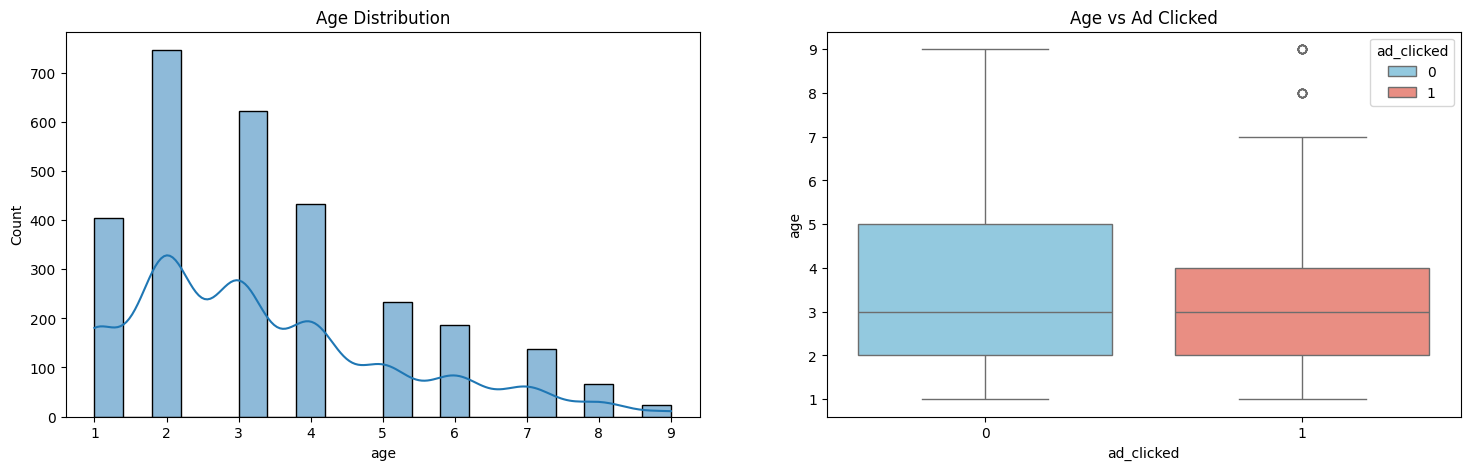

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Age distribution
sns.histplot(clean_df['age'].dropna(), kde=True, ax=axes[0], bins=20)
axes[0].set_title('Age Distribution')

# Age vs Ad Clicked
colors = ['skyblue', 'salmon']
sns.boxplot(x='ad_clicked', y='age', data=clean_df, ax=axes[1], hue = 'ad_clicked', palette=colors)
axes[1].set_title('Age vs Ad Clicked')

- From the age distribution plot, I can see that the age distribution is right-skewed.
- This means that most of the users are younger because the majority of the data points are concentrated in the lower age range.
- This skweness often occur in real world data because in multiple digital platforms, younger audience tend to be more active than older audience.
- However, since the younger audience is overrepresented, it might affect the effeciency of our model because ad behaviour might differ based on age group.

- From the boxplot, it can be seen that the users who clicked the ad tend to be younger.
- This is because , even though the median age is same in both classes, the range of ages for users who clicked on ads is more compact, meaning there is less variability among the age group that clicks ads. This could indicate that ad-clicking behavior is concentrated among younger individuals.
- There is a wider range of non-clickers,suggesting that non-clicking behavior spans across all age groups, including older individuals.
- One of the reason why most older generations are not responsive to clicking ads is because lack of age specific advertising.
- In the dataser most ads are related to technology, fashion, and entertainment which are enjoyed by most of the young audience however ads abouth healthcare, retirement planning, home improvements and so on are missing which are enjoyed by the old audience.

- So far, I can say that **"AGE"** feature shows promise as a strong indicator in determining ad-clicked behaviour because their younger audience domination might also be a reflection of their higher engagement with digital content and advertising.
- This relationship might be important for building classification models.

### Income vs. Ad clicked

Text(0.5, 1.0, 'Income vs Ad Clicked')

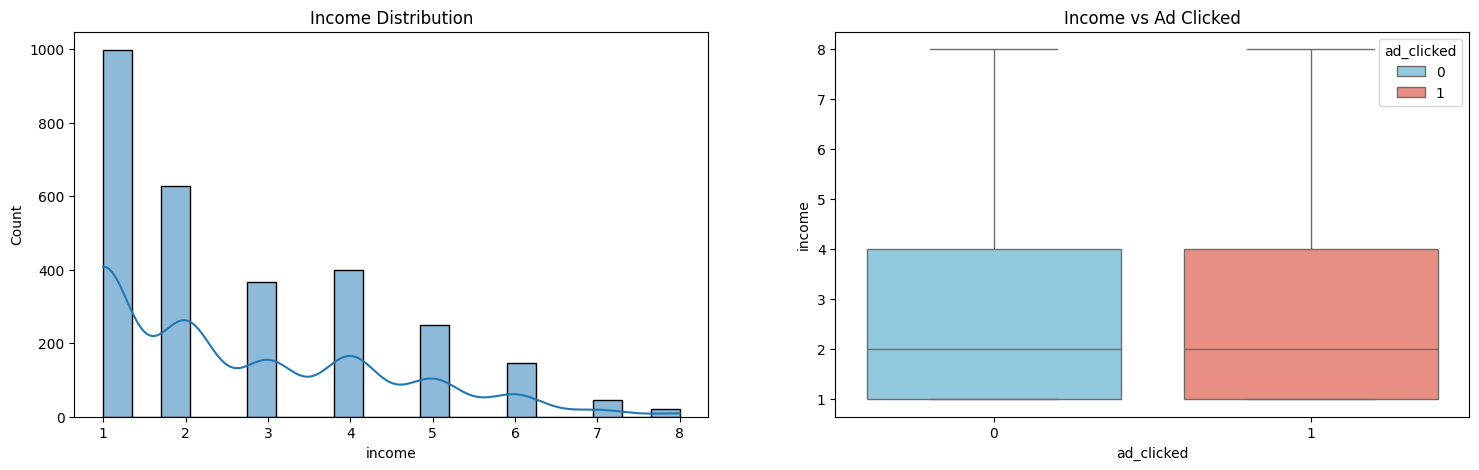

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Income distribution
sns.histplot(clean_df['income'].dropna(), kde=True, ax=axes[0], bins=20)
axes[0].set_title('Income Distribution')

# Income vs Ad Clicked
colors = ['skyblue', 'salmon']
sns.boxplot(x='ad_clicked', y='income', data=clean_df, ax=axes[1], hue = 'ad_clicked', palette=colors)
axes[1].set_title('Income vs Ad Clicked')

- From the histogram above, I can see that income distribution is slightly right skewed.
- This means that most users fall in the lower to middle income ranges, while fewer users have very high income.
- This suggests that the dataset predominantly consists of users with moderate income levels.
- Logically, income levels of users could directly influence which types of ads they are drawn to.
- For instance, ads promoting high-end products might be more appealing to wealthier individuals and budget concious ads might attract lower-income individuals.
- This means that  income can have a nonlinear relationship with ad clicks, where specific income brackets might correspond to distinct ad preferences.
- Since there are fewer users in higher-income brackets, the model might have less information about how wealthier individuals interact with ads, leading to potential bias.

- From the boxplot, it can be seen that both classes are very similar.
- There is considerable overlap between the income ranges of both groups (clickers and non-clickers).
- This means that users from similar income brackets can either click or not click on ads, suggesting that **''INCOME''** is not a decisive feature by itself.
- However, income might not be the most important factor in predicting ad-clicking behavior, it can still serve as a valuable feature when considered alongside other variables and incorporated into a broader modeling strategy.

### Education vs. Ad clicked

Text(0.5, 1.0, 'Education vs Ad Clicked')

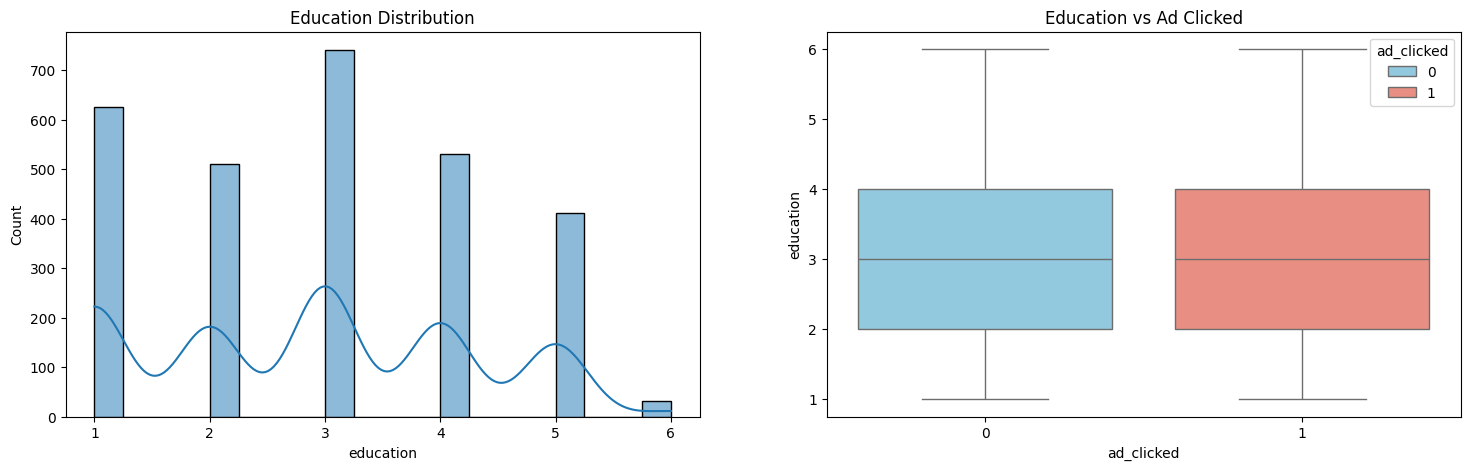

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Education distribution
sns.histplot(clean_df['education'].dropna(), kde=True, ax=axes[0], bins=20)
axes[0].set_title('Education Distribution')

# Education vs Ad Clicked
colors = ['skyblue', 'salmon']
sns.boxplot(x='ad_clicked', y='education', data=clean_df, ax=axes[1], hue = 'ad_clicked', palette=colors)
axes[1].set_title('Education vs Ad Clicked')


- As it can be seen in the graph above, education is not uniformly distributed but is clustered around a few key values.
- This may reflect meaningful categorical levels that could be useful in classification. However, no obvious relationship with ad-clicking is evident.
- No clear trend between education levels and ad clicks. The distributions overlap heavily.
- **''EDUCATION''** may not be as useful for classification, though it may still contribute in more complex models.

### Correlation heatmap

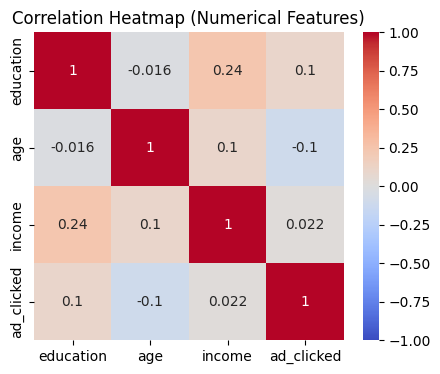

In [ ]:
#Correlation heatmap (numerical features)
plt.figure(figsize=(5, 4))
sns.heatmap(clean_df[['education', 'age', 'income', 'ad_clicked']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap (Numerical Features)')
plt.show()

- The correlation heatmap shows weak correlations between numerical features and the target ''ad_clicked''.
- For instance, age has a slightly negative correlation, and income has a marginally positive one.
- None of the numerical features show strong linear relationships with the target variable.
- This means that non-linear modeling approaches such as decision trees may perform better.

## Barplot for categorical variables

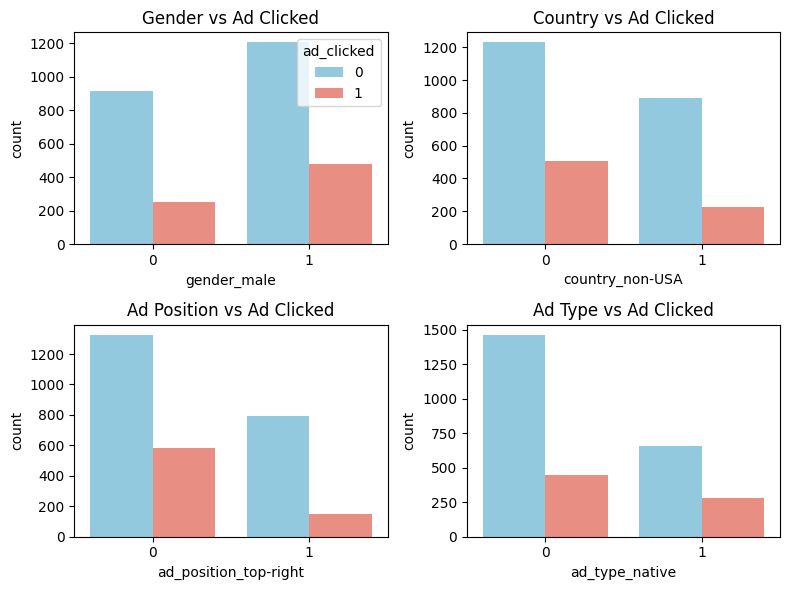

In [ ]:
# Bar plots for categorical variables
fig, axes = plt.subplots(2, 2, figsize=(8, 6))
colors = ['skyblue', 'salmon']

# Gender distribution
sns.countplot(x='gender_male', hue='ad_clicked', data=clean_df, palette=colors, ax=axes[0, 0])
axes[0, 0].set_title('Gender vs Ad Clicked')

# Country distribution
sns.countplot(x='country_non-USA', hue='ad_clicked',legend = False, data=clean_df, palette=colors,ax=axes[0, 1])
axes[0, 1].set_title('Country vs Ad Clicked')

# Ad Position
sns.countplot(x='ad_position_top-right', hue='ad_clicked',legend = False, data=clean_df, palette=colors,ax=axes[1, 0])
axes[1, 0].set_title('Ad Position vs Ad Clicked')

# Ad Type
sns.countplot(x='ad_type_native', hue='ad_clicked', legend = False, data=clean_df, palette=colors,ax=axes[1, 1])
axes[1, 1].set_title('Ad Type vs Ad Clicked')

plt.tight_layout()
plt.show()

1 = people that have clicked ads.
0 = people that have not clicked ads.

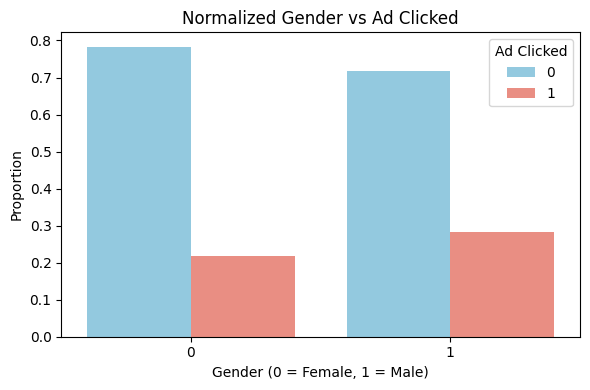

In [ ]:
# Gender distribution (normalized)
gender_ad_clicked = clean_df.groupby(['gender_male', 'ad_clicked']).size().reset_index(name='count')
gender_totals = gender_ad_clicked.groupby('gender_male')['count'].transform('sum')
gender_ad_clicked['proportion'] = gender_ad_clicked['count'] / gender_totals

fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(x='gender_male', y='proportion', hue='ad_clicked', data=gender_ad_clicked, palette=colors, ax=ax)
plt.title('Normalized Gender vs Ad Clicked')
ax.set_xlabel('Gender (0 = Female, 1 = Male)')
ax.set_ylabel('Proportion')
ax.legend(title='Ad Clicked')  #

plt.tight_layout()
plt.show()


### Gender vs Ad clicked evaluation

- It is visible from the analysis that ratio of clicked/not-clicked is higher for males. This observation suggests a trend where ad engagement differs by gender.
- While gender shows some correlation with ad-clicking behavior, the effect size is relatively small.
- This implies that while gender can be included as a feature in predictive models, it may not be a primary driver of ad clicks.
- If males show a stronger inclination to click on ads, marketers might want to tailor ad content or placements to appeal more to male audiences.
- However, since the difference is not highly pronounced, it would be important to ensure that the marketing strategies do not alienate female users, as they still represent a significant portion of the audience.
- One more thing, since the data is not normalised, then if there are significantly more males in dataset, their higher click count might simply refelect that large number and not necessarily thier higher tendency to click ads.
- That is why I have created separate graph that shows the graph with normalised data which I will discuss in next block.

### Normalised Gender vs Ad clicked evaluation

- The key insights i got from the normalised data is:
  - Around 78% of the females did not click the ads.
  - Around 22% clicked the ads.
  - Around 72% of the males did not click the ads.
  - Around 29% of the males clicked the ads.

- This confirms that males tend to click on ads at a slightly higher rate than females as the proportion of males clicking on ads (29%) is higher comapred to females (22%).

### Country(USA vs. Non-USA) vs. Ad clicked evaluation

- The analysis indicates that users from the USA clicked on ads more frequently than those from outside the USA.
- This could be due to various factors, including cultural differences, engagement levels, or ad relevance.
- The country of origin appears to be a significant factor in predicting ad-clicking behavior.
- This suggests that ads may resonate differently with users based on their geographic location, and what works in one region may not be as effective in another.

### Ad position vs. Ad clicked evaluation

-  The data shows that ads placed in the top-left position are clicked more often than those in other positions.
-  The position of an ad is a strong predictor of whether it gets clicked. This indicates that placement strategy should be a key consideration when designing digital ad campaigns.
-  If the top-left position consistently leads to higher ad click rates, marketers might want to consider placing their ads there more frequently.

### Ad type (Native) vs. Ad clicked evaluation

- Non-Native ads are more traditional advertisements, such as banners or pop-ups, that do not match the platform's content style.
- Native ads are designed to blend in with the content of the platform, making them less obtrusive. Examples include sponsored content, in-feed ads, and recommended content.
- The analysis reveals that non-native ads were clicked more frequently compared to native ads.
- This suggests that users may respond more favorably to more explicit advertising formats that stand out rather than ads that are integrated into the content.

## Log data exploration

### Count of Ad clicked by hour

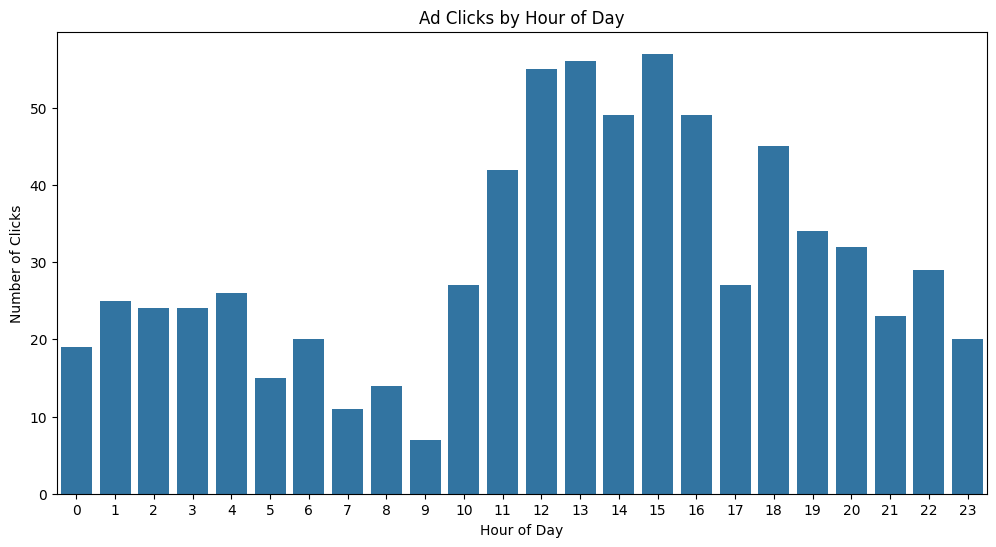

In [ ]:
#Copying df for the code
temp_log_static_df = log_static_df.copy()

# Convert timestamp to datetime
temp_log_static_df['timestamp'] = pd.to_datetime(log_static_df['timestamp'], unit='s')

# Extract date, hour, and day of week from timestamp
temp_log_static_df['date'] = temp_log_static_df['timestamp'].dt.date
temp_log_static_df['hour'] = temp_log_static_df['timestamp'].dt.hour
temp_log_static_df['day_of_week'] = temp_log_static_df['timestamp'].dt.day_name()

# Count ad clicks by hour
hourly_clicks = temp_log_static_df.groupby('hour')['ad_clicked'].sum().reset_index()

# Plotting clicks by hour
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='ad_clicked', data=hourly_clicks)
plt.title('Ad Clicks by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Clicks')
plt.xticks(range(24))
plt.show()


- The above graph displays the distribution of ad_clicks across 24 hours.
- It is clearly visbile from the grpah that during certain hours (for instance morning and evenings) ad_click activity is higher compared to the the other hours.
- One of the reason can be the user availability. Around 11, most people take a break from work or whatever they are doing and might scroll through their prefered website. During 1-3 is usually lunch hours and thats where the ad_clicked has peaked.
- The lowest rate is 9 am which is understandable because most people start working at that time.
- So just from the graph I can say that for advertisers to increase their ad_clicked rate they should time their ads during lunch time and more precisely between 12-3.
- These are the few details I can extract from the analysis.

### Count of Ad clicked by day

<ipython-input-56-2d672851ad23>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekly_clicks.index, y=weekly_clicks.values, palette=colors)


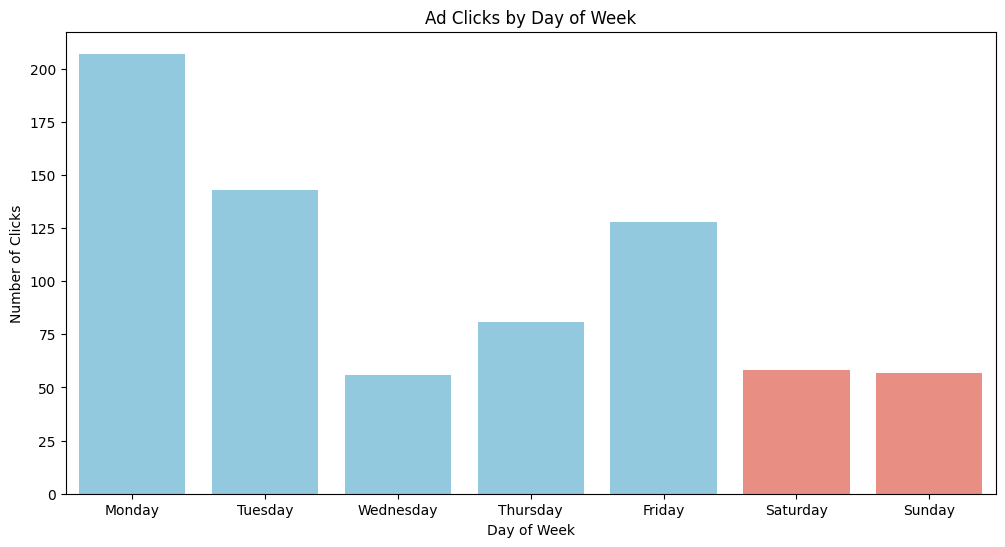

In [ ]:
# Count ad clicks by day of week
weekly_clicks = temp_log_static_df.groupby('day_of_week')['ad_clicked'].sum().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plotting clicks by day of week
colors = ['skyblue'] * 5 + ['salmon'] * 2
plt.figure(figsize=(12, 6))
sns.barplot(x=weekly_clicks.index, y=weekly_clicks.values, palette=colors)
plt.title('Ad Clicks by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Clicks')
plt.show()


- This graph highlights the distribution of ad clicks across the days of the week.
- Surprisingly, Monday is the day where the ad gets most clicked. Honestly, I was expecting that to be during weekend.
- This is the main reason of EDA, we find out the unexpected.
- One of the reasons which I think that Monday is the highest because companies tend to provide sales on items during the beginnig of the weeks.
- Apart from that, some people just reserve the weekends for their families and away from screens.
- This mighht also be the reason that full weekdays have higher ad click rates then full weekend.
- So from the graph, advertisers should provide their valuable ads on weekdays especially on Monday and Tuesdays.
- These are the few things I manage to conclude from the above analysis.

### Average Total time by weekdays

The main reason I wanted to do this visualisation was to check whether there is correlation between the amount of time spent and ad_clicked. We checked total ad_clicked per day in our last analysis. This will help us check the time spent.

In [ ]:
#I forgot to create one more dataframe but its simple so I just did here. It just removes the column that has 5 million total time because it ruins the visualisation.
log_static_df2 = pd.merge(log_df, clean_df, on='log_id', how='left')
log_static_df2 = log_static_df2[log_static_df2['log_id'] != 20180904200856]
log_static_df2.loc[log_static_df2.duplicated('log_id', keep = 'first'), ['total_time']] = 0

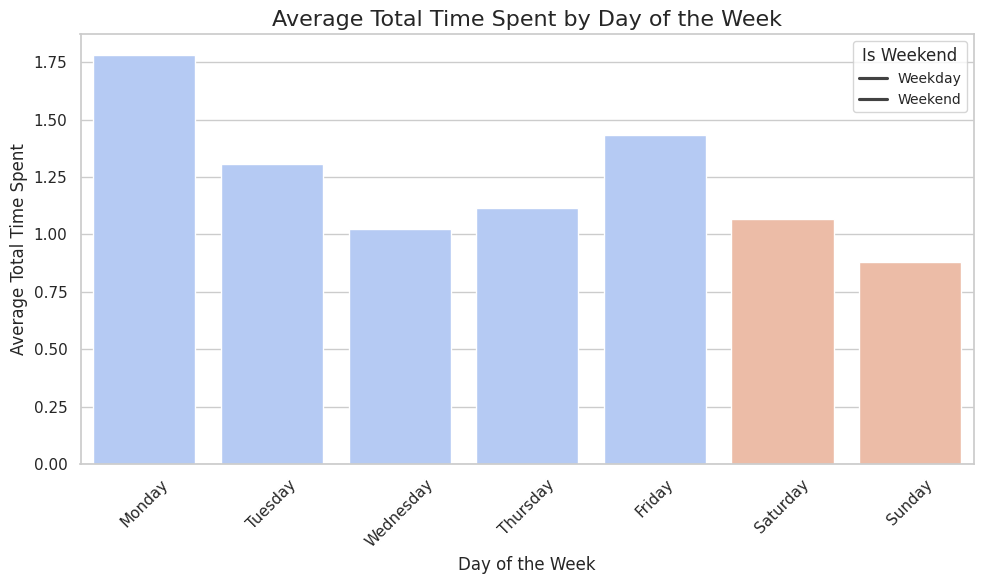

In [ ]:
data = log_static_df2.copy()

# Convert the timestamp to a datetime format
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s')

# Extract day of the week and create a weekday/weekend flag
data['day_of_week'] = data['datetime'].dt.day_name()
data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday'])

# Aggregate total_time by day of the week and weekend/weekday
seasonality_summary = data.groupby(['day_of_week', 'is_weekend'])['total_time'].mean().reset_index()

# Sort the days of the week in order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
seasonality_summary['day_of_week'] = pd.Categorical(seasonality_summary['day_of_week'], categories=day_order, ordered=True)
seasonality_summary = seasonality_summary.sort_values('day_of_week')


#Plotting
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(
    data=seasonality_summary,
    x='day_of_week',
    y='total_time',
    hue='is_weekend',
    palette='coolwarm',
    dodge=False
)
plt.title('Average Total Time Spent by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Total Time Spent', fontsize=12)
plt.legend(title='Is Weekend', labels=['Weekday', 'Weekend'], fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- As expected, there is a clearly contrast between weekday and weekends.
- People spend most time on Monday, which is equal to previous analysis where Monday being the day with the most ad_clicked.
- As the week proceeds, the time spent decreases and starts to peak on Thurday and Friday.
- This pattern is exactly similar to the counts of adclicked per day.
- This shows that there is direct correlation between total time spent on a day on a webpage to total ad clicked in a day.

### Average Total time spent by ad categories

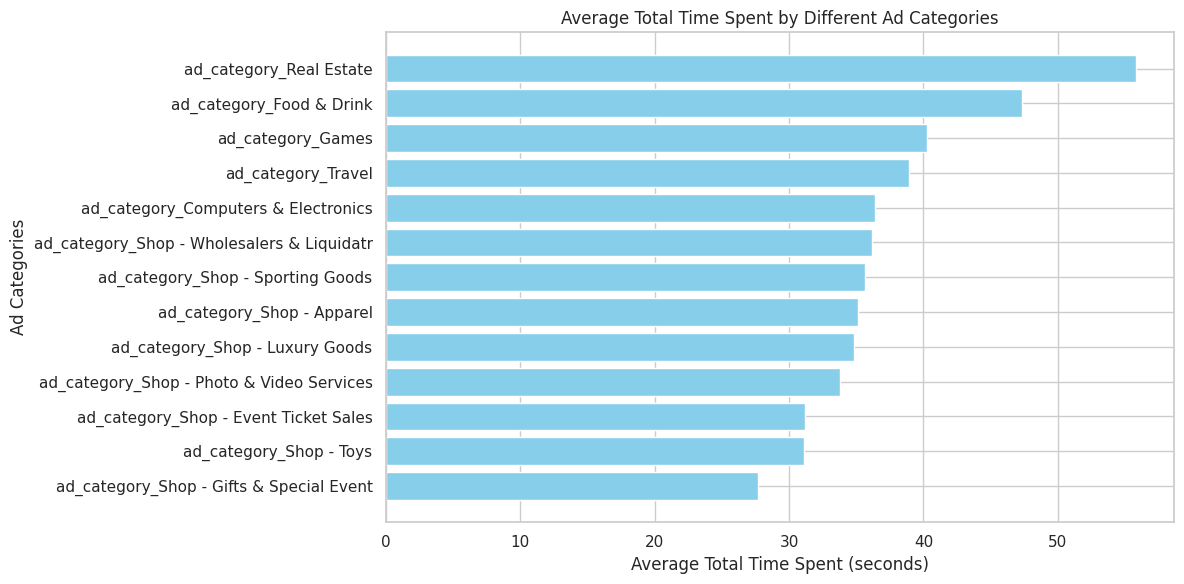

In [ ]:
# data = PGL_agg_df2.copy()
data = PGL_agg_WO_df.copy()

ad_categories = [col for col in data.columns if col.startswith('ad_category_')]
ad_data = data[ad_categories + ['total_time']]

# Calculate the average total time spent by each ad category
average_time_per_category = {}
for category in ad_categories:
    average_time = data.loc[data[category] == 1, 'total_time'].mean()
    average_time_per_category[category] = average_time

# Convert to a DataFrame for visualization
avg_time_df = pd.DataFrame(list(average_time_per_category.items()), columns=['Ad Category', 'Average Total Time'])
avg_time_df = avg_time_df.sort_values(by='Average Total Time', ascending=False)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.barh(avg_time_df['Ad Category'], avg_time_df['Average Total Time'], color='skyblue')
plt.xlabel('Average Total Time Spent (seconds)')
plt.ylabel('Ad Categories')
plt.title('Average Total Time Spent by Different Ad Categories')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

- I used the data set where the outliers are handled and are capped at lower and upper bound.
- From the analysis, it is visble that the ad_Category which attracts more people to spend time on is real estate and followed by food and drinks.
- I would have assumed that most working audience will be interested in the real estate, however just in the next analysis it can be seen that all age groups spend similar amount of time.
- This shows that even the teens are interested in real estate and especially in this generation where every information is available online to understand the market.
- One of the thing advertisers can use from this analysis is they can try to promote real estate that are not humoungously expensive but in a sweet range where teenager can consider. This way it benefits both parties.
- Second ranked is food and drink but that was expected because after covid most people got habbit of odering food online rather than dinning outside. Thats is why they are always lookout for new place in town or a good discount for family meal.
- I think the advertisers are also aware about this fact because food ads are in competition with real estate which is always in demand. So, they are doing pretty good job.

### Total time vs. Age

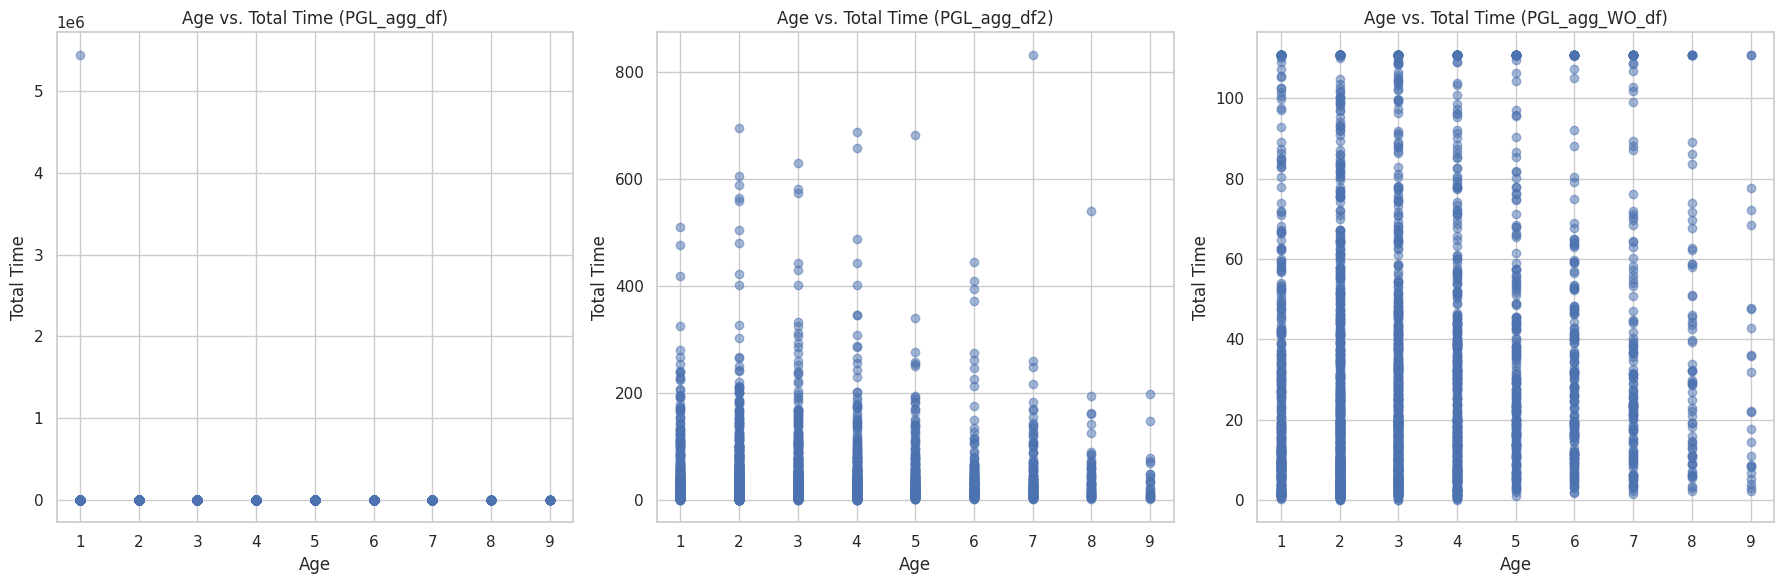

In [ ]:
import matplotlib.pyplot as plt

datasets = [(PGL_agg_df, 'PGL_agg_df'), (PGL_agg_df2, 'PGL_agg_df2'), (PGL_agg_WO_df, 'PGL_agg_WO_df')]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.subplots_adjust(wspace=0.4)

for ax, (data, title) in zip(axs, datasets):
    ax.scatter(data['age'], data['total_time'], alpha=0.5)
    ax.set_title(f'Age vs. Total Time ({title})')
    ax.set_xlabel('Age')
    ax.set_ylabel('Total Time')

plt.tight_layout()
plt.show()


- I did the analysis side by side, so the difference between the graphs is easy to analyse.
- PGL_agg_df
  - The first graph I created using the raw dataframe where no outliers was handles.
  - It is clearly visible that there is presense of a significant outliers. Also because all the data are plotted at y = 0 apart from 1.
  - If we would have used this data for prediction, the extreme outliers might have biased our model. This shows that preprocessing is really required for this data.
  - Also we are unable to see any sort of trend due to the significant outlier.

- PGL_agg_df2
  - After I did the above visualisation in my draft, I decided to find out about this significant outliers by sorting the dataframe in descending order.
  - I found out that the first row in total_time column had 5 million seconds , the following 5 rows had something like 4000, 3000 , 2500, 2000  and 2000. The next rom from there was like 800.
  - So I thought of removing the first 6 extreme values and see the difference in the graph.
  - After removing the 6 outliers, the scatterplot shows less skewed distribution. The range of total_time has also massively reduced.
  - However, the overall pattern between age and total_time still remains unclear.

- PGL_agg_WO_df
  - I was still not satisfied with the above visualisation so I decided to find out the true outliers and capp the data at lower and upper bound and see if it shows any relation.
  - That is the third graph.
  - After capping, the range of total_time is narrower and more uniform.
  - Unlike the second dataset, no data points are removed but extreme values are simply adjusted to fall within acceptable range.
  - It can be noticed that most age group have similar time spent on the webpage. only the last 2 age group which 8 and 9 has considerable lower time but this is understandable because there are older generation who are not much tech savvy. On average people tend to spend atleast 1 minute on the webpage.

- Summary
  - Overall, in all 3 datasets reveals weak or no apparent correlation between age and total_time.


### Total time vs. Total clicks

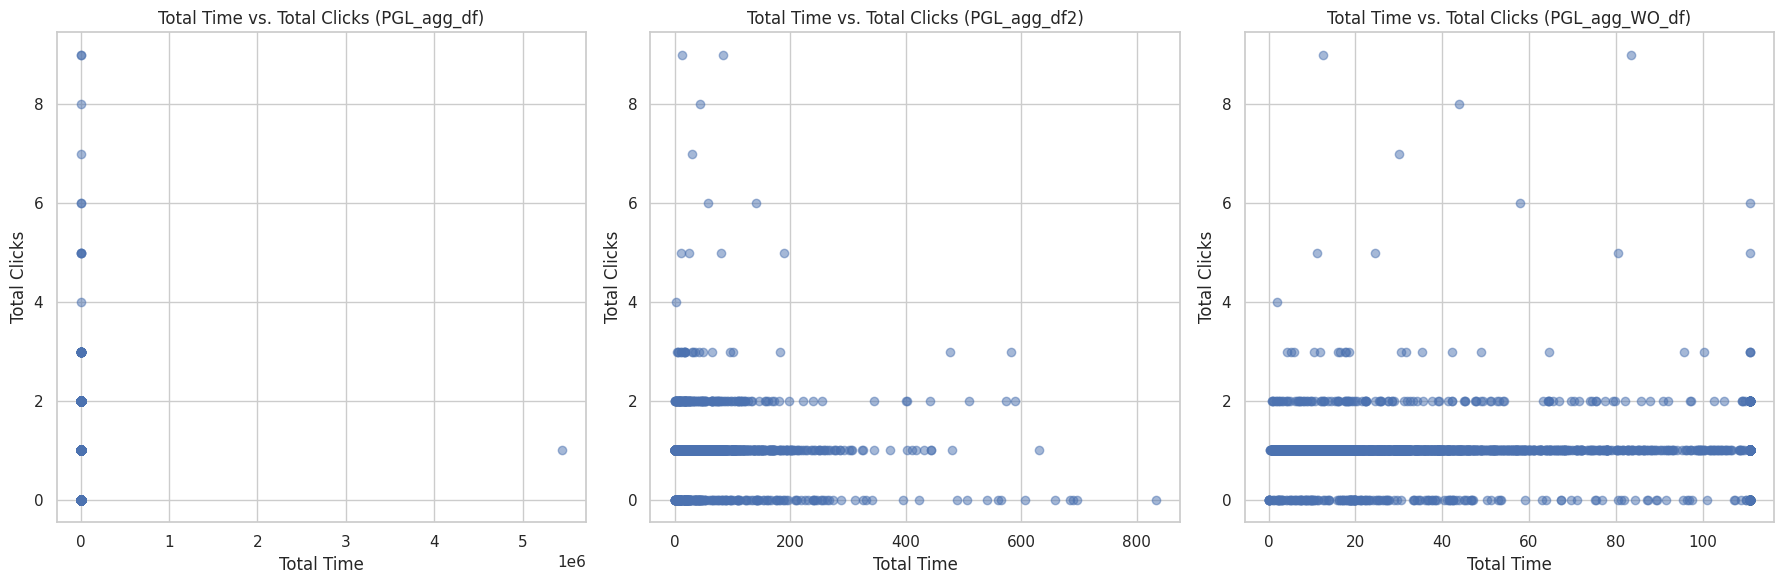

In [ ]:
import matplotlib.pyplot as plt


datasets = [(PGL_agg_df, 'PGL_agg_df'), (PGL_agg_df2, 'PGL_agg_df2'), (PGL_agg_WO_df, 'PGL_agg_WO_df')]
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.subplots_adjust(wspace=0.4)

for ax, (data, title) in zip(axs, datasets):
    ax.scatter(data['total_time'], data['total_click'], alpha=0.5)
    ax.set_title(f'Total Time vs. Total Clicks ({title})')
    ax.set_xlabel('Total Time')
    ax.set_ylabel('Total Clicks')


plt.tight_layout()
plt.show()

- I wanted to visualise this records because I thought the higher the time they spend on a webpage, logically they would tend to click more on the webpage even if it is not an ad but clicking to know more about ads.
- If my hypothesis was right then the graph would have shown a better correlation.
- However, in the first graph which was created using the raw data, personally, I would say it is completely useless but I wanted to keep it just so I can see the difference and how it would have affected if I had used that data for modelling.
- Overall, there is a slight correlation that the more time they spend, the more they click but nothing significant.
- Most people only click once on the webpage and that too I assume that is to know more about the ad and just go back to their normal search.

## Key Points

- Just by visualising and evaluating on a surface level we managed to extract so much information.
- We found out that age, income, country, ad_postion and ad_type might be very good predictors whether the customer clicks on ads or not.
- Also, gender and education might not be that significant predictor but might still be helpful if we combine with other variables.
- TIme based features could also be valuable, as ad clicks show clear temporal patterns. For example, more clicks at lunch time and during specific days.
- Variables like ad position and ad type show strong interaction effects with ad clicks, suggesting that simple linear models may miss important patterns.
- Given the non-linear nature of the relationships, decision trees, random forests, and XGBoost are likely to be the most suitable models. These models can capture the complex patterns between predictors and ad clicks, while also handling interactions and non-linearity efficiently.
- However, I still want to find out how it performs on linear models so I will be using logistic regression out of curiosity.

# Evaluation Criteria

My task is classification based and my data in imbalanced (this means that there are more data points of one class compared to other). In this scenario, focusing on **F1-SCORE** of minority rather than accuracy will provide more effective result. There are few reasons why I will be focusing more on f1 score through out the project which are as follows:

- **Accuracy pitfall** - In scenarios where the dataset is imbalanced,  high accuracy can be misleading because a model could predict the majority class (non-clicks) well, achieving a high accuracy score while completely failing to identify the minority class (clicks). Eventhough I will balance the data for training purpose, the test data or the real data will most likely never be balanced.

- **Comprehensive evaluation** - F1 score is the harmonic mean of precision and recall, which means it provides a single metric that balances both false positives and false negatives. This is especially important in advertising contexts where both types of errors can have significant consequences.

- **Business relevance** - In my case, false negatives (not predicting a click when it happened) could mean lost opportunities for ad revenue, while false positives (predicting a click when it didn’t happen) could lead to wasted advertising budget. The F1 score helps you find a balance that aligns with the business goals.

- **Fair comparison across models** - When evaluating different models (e.g., Random Forest, Decision Tree, Logistic Regression, XGBoost), using F1 score allows for a fair comparison that emphasizes their ability to identify relevant instances (clicks) rather than being influenced by the overall number of predictions.

## Evaluation Functions

I have found this code in github and just slightly modify the code to fit my models. The code is pretty easy to understand. I am using this to avoid repeatation of the code.

In [ ]:
def print_metrics(y_true, y_pred):
    '''Print accuracy score, confusion matrix, and classification report.'''

    # Calculate metrics
    acc_score = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report = classification_report(y_true, y_pred)

    print('Accuracy:', acc_score)
    print('-------')
    print('F1 Score:', f1)
    print('-------')
    print('Classification report:')
    print(class_report)

    # Display confusion matrix
    print('-------')
    print('Confusion matrix (visualized below):')
    ConfusionMatrixDisplay(conf_matrix).plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

# Defines a function to visualize feature importances
def plot_feature_importances(model, x):
    '''Display barplot representing a model's feature importances.    '''
    n_features = x.shape[1]
    plt.figure(figsize=(8,10))
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), range(1, n_features+1))
    plt.xlabel("Feature importance")
    plt.ylabel("Feature (Component)")
    plt.title('Feature Importances')

#Defines a function to store the model results
def store_model_results(model_name, precision, recall, f1, results_dict):
    '''Store Recall, Precision, and F1 score for a specific model in the dictionary.'''

    results_dict[model_name] = {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

model_results = {}


# Preprocessing

This section will be used to manipulate data for the modeling. These section contains few main steps as follows:
- It will split the data into 3 groups. One will be training set , one will be validation set which will be used for hyperparameter tuning and finally the test set which will help me to evaluate the final version of each model.
- Second step will be to resample the training set so that all classes that are imbalanced ad we saw in the visualisation will be equally represented.
- Next step will be to scale the data. This will help ensure that PCA and other algorithms work wihtout encountering an error.
- Lastly, we will use Principal Components Analysis, which will help us to reeduce the dimensionality of the data and prevent any multicolliniarity.



I will execute all the above steps in the training data first which will help me crosscheck result of the each step. Once complete, I will keep the important processing steps in the pipeline that I will later use to transform the validation and test sets.

## Train - Validation - Test Split

- First I will do the train-test split. Step to note is that I will be making two different splits. In the first split, I take 70% of the whole dataset to use as my training data.
- Then I take remaining 30% dataset and split that into half where 15% will be used for validation (hyperparameter tuning) and final 15% will be used only once at the end to evaluate my best model.
- One more thing to note is that I am doing stratified spliting. This ensures that each subset will have same proportion of both classes as in the original dataset.

In [ ]:
#First split: Train-Test Dataset
X = model_df.drop(['ad_clicked', 'log_id'], axis=1)
y = model_df['ad_clicked']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 786, stratify=y)

In [ ]:
#Second Split: Validation - True holdout (test) datasets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=786, stratify=y_test)

In [ ]:
# Examine shapes of the subsets
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(1750, 32) (1750,)
(375, 32) (375,)
(376, 32) (376,)


Once I finish modelling, I want to compare the results of the model how it performs on the raw data and the data that has been processed. So, to preserve the raw data splits, I will just make its copies now.

In [ ]:
# Save raw copies of train and validation sets before further preprocessing
X_train_raw = X_train.copy()
y_train_raw = y_train.copy()

X_val_raw = X_val.copy()
y_val_raw = y_val.copy()

## Resampling

First, I will check the distribution ratio of the data classes and then I see if resampling is needed.

In [ ]:
y_train.value_counts()

,count
ad_clicked,
0,1341
1,409


- As it can be seen above that the classes are really imbalanced.
- My next step is to handle the class imbalance. My strategy is to use SMOTE-NC to oversample the data. This is because our data is not that huge so adding more data might help in the model and also it will not have any data leakage.
- The mix of numeric and one-hot encoded categorical features makes SMOTE-NC the most appropriate choice for oversampling.
- SMOTE-NC treats numeric columns as continuous and uses interpolation to create synthetic samples.
- SMOTE-NC identifies categorical columns and ensures new samples belong to valid categories. It assigns the mode (most frequent value) for categorical features when generating synthetic samples.
- My aim is to make both classes to be 1341 data points.

In [ ]:
#Specifying categorical columns
categorical_indices = list(range(16, 32))

# Apply SMOTE-NC
smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=786)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

In [ ]:
# Check the new class distribution
y_resampled.value_counts()

,count
ad_clicked,
1,1341
0,1341


I have managed to get both class to be equal as seen above.

## Scaling

The next next transformation will be to standardise the data. Even though it does not really affect models likie random forest or decision trees, it might support complex models plus it does not negaltively affect random forest so I will do it now.

In [ ]:
# Scale the resampled features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)
X_scaled = pd.DataFrame(X_scaled)

I will scale my raw data as well which has not been oversampled because I want to use class weight to manage the imbalance and see the difference in performance.

In [ ]:
#Scaling the raw features
X_raw_scaled = scaler.fit_transform(X_train_raw)
X_raw_scaled = pd.DataFrame(X_raw_scaled)
X_val_raw_scaled = scaler.fit_transform(X_val_raw)
X_val_raw_scaled = pd.DataFrame(X_val_raw_scaled)

In [ ]:
# Check the results
X_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,2682.000,2682.000,2682.000,2682.000,2682.000,2682.000,2682.000,2682.000,2682.000,2682.000,...,2682.000,2682.000,2682.000,2682.000,2682.000,2682.000,2682.000,2682.000,2682.000,2682.000
mean,0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,...,-0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,...,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-0.958,-0.874,-0.135,-0.603,-0.133,-0.359,-0.061,-0.060,-11.839,-0.186,...,-0.058,-0.402,-0.132,-0.097,-0.356,-0.236,-0.217,-0.173,-0.147,-0.252
25%,-0.958,-0.874,-0.135,-0.603,-0.133,-0.359,-0.061,-0.060,0.084,-0.186,...,-0.058,-0.402,-0.132,-0.097,-0.356,-0.236,-0.217,-0.173,-0.147,-0.252
50%,-0.123,-0.269,-0.135,-0.603,-0.133,-0.359,-0.061,-0.060,0.084,-0.186,...,-0.058,-0.402,-0.132,-0.097,-0.356,-0.236,-0.217,-0.173,-0.147,-0.252
75%,0.620,0.626,-0.135,1.505,-0.133,-0.359,-0.061,-0.060,0.084,-0.186,...,-0.058,-0.402,-0.132,-0.097,-0.356,-0.236,-0.217,-0.173,-0.147,-0.252
max,4.759,8.032,7.408,5.721,33.118,6.239,34.209,28.741,0.084,25.694,...,17.234,2.488,7.570,10.309,2.807,4.229,4.601,5.778,6.786,3.970


The features has been standardized and it can be seen that all have a mean of 0 and standard deviation of 1.

We have finished scaling the training data. Next step is PCA.

## PCA

- PCA, or Principal Component Analysis, is a technique used to simplify data while retaining its most important information.
- PCA helps reduce the number of features by creating new ones that summarize the original data. These new features are called "principal components."
-  PCA looks for patterns in the data, finds the directions in which the data varies the most, and then transforms the data along these directions. These directions are the principal components. The idea is to keep the components that capture the most variation in the data, which contain the most important information.
- Even though my data consist of only 32 columns, I want to feed my model best data and PCA helps to reduce noice and simplifies the data.
- For my analysis below, my aim is to find the component number that explains aleast 80% of the variance.

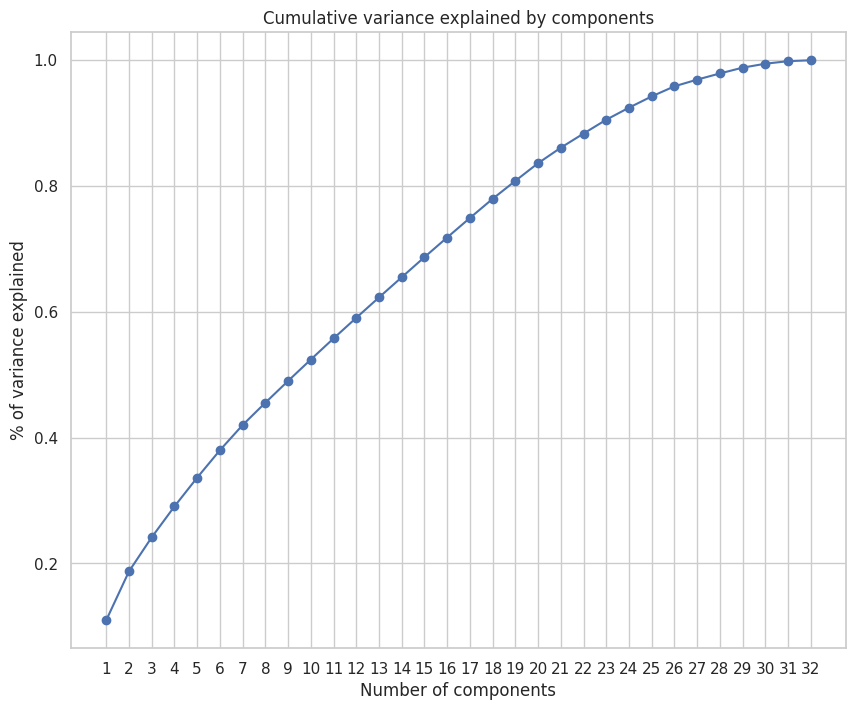

In [ ]:
# Fit PCA once and calculate cumulative explained variance
# I took gpt's help for the graph but the code is pretty simple

pca = PCA().fit(X_scaled)
var_sums = np.cumsum(pca.explained_variance_ratio_)

# Visualize results
plt.figure(figsize=(10, 8))
plt.plot(range(1, len(var_sums) + 1), var_sums, marker='o')
plt.xlabel('Number of components')
plt.ylabel('% of variance explained')
plt.title('Cumulative variance explained by components')
plt.xticks(range(1, len(var_sums) + 1))
plt.grid(True)
plt.show()

- Nineteen (19) components looks like is capturing 80%+ variation of the data. This fullfills our criteria.
- Using less features will also prevent overfitting in the training data, however it might cost us the accuracy little bit.
- I can do that trade because I will be focusing more on f1 score which I have mentioned in 'evaluation criteria' section in more detail.

## Preprocessing Pipeline

- I am aware that I have to transform my data so that it is standardised and have 19 components.
- To simplify the process and prevent any data leakage, I will use a pipeline that will transform my data as same as training data.

In [ ]:
# Build a pipeline for the preprocessing steps
pipe_pp = Pipeline([('scaler', StandardScaler()),
                        ('pca', PCA(n_components=19))])

I will fit the preprocessing pipeline to the resampled train data and then I will use the pipeling to transform the validation and test sets separately.

In [ ]:
# Fit the pipeline and transform the training dataset
X_train_trans = pipe_pp.fit_transform(X_resampled)

In [ ]:
# Use the pipeline to transform the validation and test datasets
X_val_trans = pipe_pp.transform(X_val)
X_test_trans = pipe_pp.transform(X_test)

Final step will be to make a copy of my un-preprocessed training label and give more understandable label

In [ ]:
# Apply naming conventions to the un-preprocessed labels
y_train_res = y_resampled.copy()

# Testing Multiple Algorithms

In the following sections, I will explore four different models to find the model that can classify ad_clicked with the highest f1-score.

**Logistic Regression** - It is a statistical method used for binary classification that models the probability of a binary outcome based on one or more predictor variables. It estimates the relationship between the dependent variable and independent variables using a logistic function, making it suitable for classification problems where the outcome is categorical. It will be my simple linear baseline model.

**Decision Tree** - A decision tree is like a flowchart that helps you make decisions. It starts with a question or condition at the top (the "root") and branches out based on answers or choices. Each branch leads to another question or a final decision (the "leaf"). It's a simple way to break down complex problems step by step, like sorting or predicting outcomes. It will be my non-linear baseline model.

**Random Forest**- It uses multiple decision trees to predict labels for observation instead of one tree like decision tree.

**XGBoost** - is an ensemble method that trains a series of weak learners to work in sequence to predict labels. This is typically considered a more flexible and powerful type of algorithm than a Random Forest.

**N.B - I was planning to try out LSTM as well even though the data is very small for the deep learning models but due to time constraint I was not able to do it. However, I have mentioned the steps or more like my thought process of how I would have attempted the model.**

**NOTE: At the beginning of each model, I have given brief description on how many variation of each models I will create.**

## Logistic Regression

I will be creating logistic regression with three separate data set.
- One will use the dataset that has been oversampled only to handle the class imbalance.
- One will use the dataset that has been fully transformed using scaling & PCA.
- One will use raw data set that has been scaled but will use class weight to handle the class imbalance.

The different variation will help us to compare the models performance and see which gives best results.

### Logistic Regression 1

#### Baseline Model

- This model will use the data that has been only resampled and not transformed.

- First, I will instantiate the logistic regression, fit the training data and look at the accuracy, f1 score, confusion matric and classification report.

- The main reason for me to predcit whatever we just fed to model is to see if it is overfitting or not.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.7692020879940343
-------
F1 Score: 0.7703153988868274
-------
Classification report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.77      1341
           1       0.77      0.77      0.77      1341

    accuracy                           0.77      2682
   macro avg       0.77      0.77      0.77      2682
weighted avg       0.77      0.77      0.77      2682

-------
Confusion matrix (visualized below):


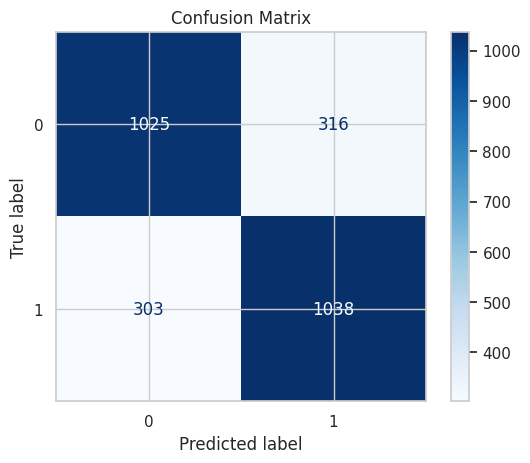

In [ ]:
#Fit & score a baseline Logistic Regression
log_reg1 = LogisticRegression(random_state = 786, max_iter=1000)
log_reg1.fit(X_resampled, y_resampled)

train_pred = log_reg1.predict(X_resampled)

print_metrics(y_resampled, train_pred)

As it can be seen that model's performance is fairly consistant between both the classes and the overall accuracy suggests that it's generalising reasonably well to the data. This means that overfitting is not our major concern here.

Accuracy: 0.7173333333333334
-------
F1 Score: 0.36904761904761907
-------
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       288
           1       0.38      0.36      0.37        87

    accuracy                           0.72       375
   macro avg       0.60      0.59      0.59       375
weighted avg       0.71      0.72      0.71       375

-------
Confusion matrix (visualized below):


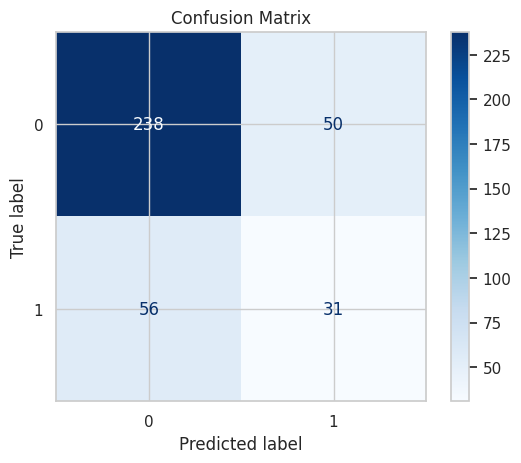

In [ ]:
#I will just try to see that model's accuracy on the raw data that has not been oversampled yet.
val_pred = log_reg1.predict(X_val_raw)

print_metrics(y_val_raw, val_pred)

- Now I can see the reality of the model's performacnce on the raw data.
- The accuracy is similar however it is predicting the majority class way better.
- However, we are more interested in the f1 score of the minority as it was explained at the beginning. Our aim is to get the best f1 score for the minority.
- This model on the raw data is giving 0.37 f1 score for the minortiy.
- Now lets see how introducing other parameter can enhance the model using random search.

#### Hyperparameter Tuning Using Random Search

This time round I will be using random search to tune my hyperparameters rahter than gridsearch. This is because I am not really sure which range is ideal for the tuning. This issue will be sorted when I use random search and it will return the best parameters I can use for the model.
- I will be using f1-score for measurement and pos_label = 1 parameter will make sure that it compares f1 score for minority.

In [ ]:
param_dist = {
    'C': [0.01, 0.1, 0.6, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Set up cross-validation and scoring
cv = StratifiedKFold(n_splits=5)
scorer = make_scorer(f1_score, pos_label=1)

rand_log_reg_1 = RandomizedSearchCV( estimator=log_reg1, param_distributions=param_dist, n_iter=100, scoring=scorer, cv=cv, random_state=786, n_jobs=-1)
rand_log_reg_1.fit(X_resampled, y_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=LogisticRegression(max_iter=1000,
                                                random_state=786),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.01, 0.1, 0.6, 1, 10],
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear', 'saga']},
                   random_state=786,
                   scoring=make_scorer(f1_score, response_method='predict', pos_label=1))

In [ ]:
# View best score and parameters
print('Best score:', rand_log_reg_1.best_score_)
print('Best params:', rand_log_reg_1.best_params_)

Best score: 0.7421455366570097
Best params: {'solver': 'liblinear', 'penalty': 'l2', 'C': 1}


- The best option by the random search had f1 score of 74% and the best parameters are as listed above.
- However, I still want to check the full results of the random search and see what other parametes provide and select the best overall.

#### Evaluating Random Search Results

I want to briefly evaluate the full result and see if i can find anything important.

In [ ]:
results_df = pd.DataFrame(rand_log_reg_1.cv_results_)
display(results_df[['param_C', 'param_penalty', 'param_solver', 'mean_test_score', 'std_test_score']].sort_values(by='mean_test_score', ascending=False))

,param_C,param_penalty,param_solver,mean_test_score,std_test_score
14,1.000,l2,liblinear,0.742,0.131
10,0.600,l2,liblinear,0.742,0.126
12,1.000,l1,liblinear,0.742,0.143
16,10.000,l1,liblinear,0.739,0.149
8,0.600,l1,liblinear,0.739,0.141
18,10.000,l2,liblinear,0.738,0.148
6,0.100,l2,liblinear,0.733,0.100
4,0.100,l1,liblinear,0.716,0.081
2,0.010,l2,liblinear,0.706,0.056
13,1.000,l1,saga,0.656,0.017


- As expected the best mean score is not really representing best hyperparameters in my opinion.
- I want to find the parameters that provide good mean score but also lower standard deviation.
- This is because ower standard deviation means the model's performance is more consistent across different folds of cross-validation, while a higher standard deviation suggests that the performance varies significantly.
- So, I am looking for a region where the mean score is somewhat similar to the best but has lower standard deviation because that will indicate a stable performance.
- The best parameters provided by the search has mean score of 0.742 but it also had relatively higher standard deviation (0.131, 0.126, 0.143) that shows that the performance was varying between the folds.
- However, the parameters that caught my eye is in row number 6 where the mean score has slightly dropped but standard deviation is relatively much lower (0.100). This shows that there is more stable performance across the folds.
- I feel row 6 parameters are the best choice for this model because lower standard deviation (0.100) indicates more consistency.
- I will be using the similar logic to find better hyperparameters in the other models as well but I will not explain the reasoning because it will just sound repetative.
- The only thing to note is that similar mean score and relatively lower standard deviation is a better choice for hyperparameters and that is what I will look for in other models.

Now I will examine the optimised model on validation data.

Accuracy: 0.7173333333333334
-------
F1 Score: 0.39080459770114945
-------
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.82      0.82       288
           1       0.39      0.39      0.39        87

    accuracy                           0.72       375
   macro avg       0.60      0.60      0.60       375
weighted avg       0.72      0.72      0.72       375

-------
Confusion matrix (visualized below):


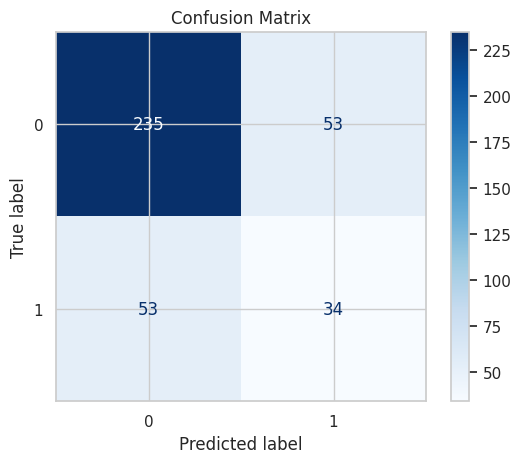

In [ ]:
log_reg1 = LogisticRegression(C=0.100, penalty='l2', solver='liblinear', random_state=786, max_iter=1000)
log_reg1.fit(X_resampled, y_resampled)

#View validation metrics for the best model
y_pred = log_reg1.predict(X_val_raw)
print_metrics(y_val_raw, y_pred)

The optimised Logistic Regression scored F1 score of 39% on the validation set. The confusion matrix and classification report shows the model hs f1 score for minority. I will be comparing the next models to see if they provide any better results.

In [ ]:
#Storing the results for Logistic Regression Optimised Model
store_model_results('Log_reg_1', 0.39, 0.39, 0.39, model_results)

### Logistic Regression 2

The second Logistic Regression will use the data that has been processed.

#### Baseline Model

First as usual, I will fit in the model on the transformed data to see the perfromacne.

Accuracy: 0.6756152125279642
-------
F1 Score: 0.6895074946466809
-------
Classification report:
              precision    recall  f1-score   support

           0       0.69      0.63      0.66      1341
           1       0.66      0.72      0.69      1341

    accuracy                           0.68      2682
   macro avg       0.68      0.68      0.67      2682
weighted avg       0.68      0.68      0.67      2682

-------
Confusion matrix (visualized below):


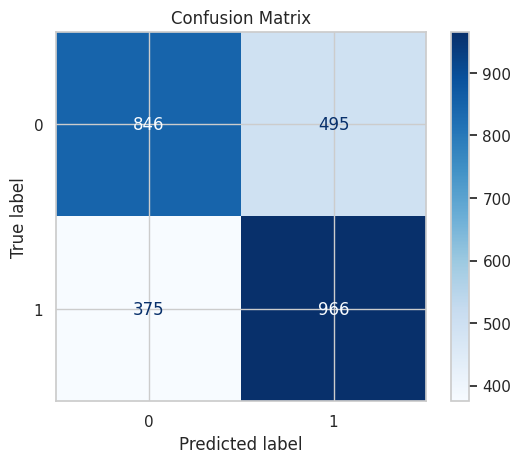

In [ ]:
#Fit & score a baseline Logistic Regression2
log_reg2 = LogisticRegression(random_state = 786, max_iter=1000)
log_reg2.fit(X_train_trans, y_train_res)

train_pred = log_reg2.predict(X_train_trans)
print_metrics(y_train_res, train_pred)

- The results for the transformed data are worse.
- One of the reaasons might be becaust the PCA changes the data structure, so it can make harder for logistic regression to find decision boundary.
- For this model it can be seen that PCA has negatively affected the model's performance.
- I was planning to tune the hyperparameters here but I don't really think that there will be any better performance so I will not do it but I will try to use the class_weight option and see what is the difference in models performance.




Accuracy: 0.656
-------
F1 Score: 0.3827751196172249
-------
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       288
           1       0.33      0.46      0.38        87

    accuracy                           0.66       375
   macro avg       0.57      0.59      0.57       375
weighted avg       0.70      0.66      0.67       375

-------
Confusion matrix (visualized below):


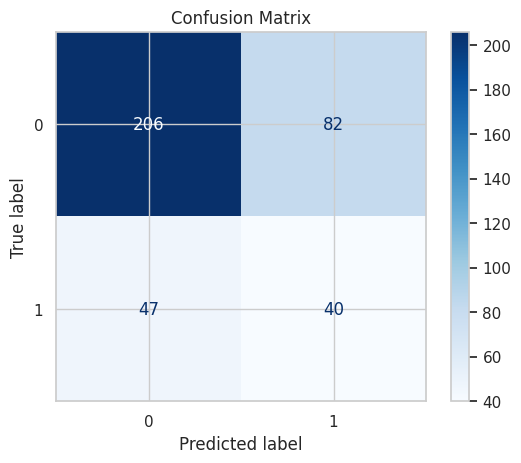

In [ ]:
#I will still run in the unseen data for the comparison sake
val_pred = log_reg2.predict(X_val_trans)
print_metrics(y_val, val_pred)

In [ ]:
#Save the results
store_model_results('Log_reg_2', 0.33, 0.46, 0.38, model_results)

In [ ]:
#confirming the addition of results
model_results

{'Log_reg_1': {'Precision': 0.39, 'Recall': 0.39, 'F1 Score': 0.39},
 'Log_reg_2': {'Precision': 0.33, 'Recall': 0.46, 'F1 Score': 0.38}}

### Logistic Regression 3

For this model, I will use raw data that has only scaled and no other transformation.

Accuracy: 0.6417142857142857
-------
F1 Score: 0.47793505412156534
-------
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.62      0.73      1341
           1       0.36      0.70      0.48       409

    accuracy                           0.64      1750
   macro avg       0.62      0.66      0.60      1750
weighted avg       0.75      0.64      0.67      1750

-------
Confusion matrix (visualized below):


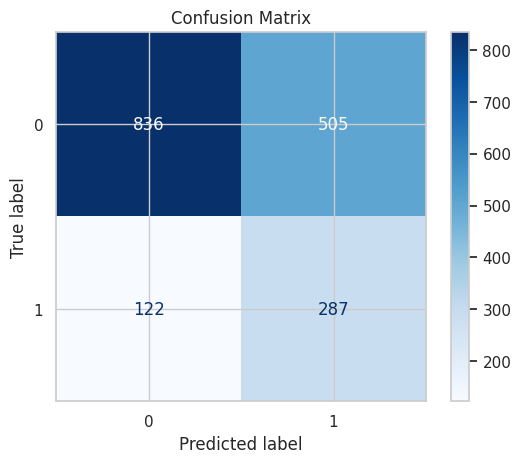

In [ ]:
log_reg_3 = LogisticRegression(class_weight = 'balanced', random_state = 786, max_iter=1000)
log_reg_3.fit(X_raw_scaled, y_train_raw)

train_pred = log_reg_3.predict(X_raw_scaled)
print_metrics(y_train_raw, train_pred)

- As expected, this performace is the worst among all.
- This proves what we found during EDA that non-linear models are more suitable for our dataset.
- However, it was worth trying to prove the hypothesis right.

Accuracy: 0.6586666666666666
-------
F1 Score: 0.4482758620689655
-------
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.68      0.75       288
           1       0.36      0.60      0.45        87

    accuracy                           0.66       375
   macro avg       0.60      0.64      0.60       375
weighted avg       0.73      0.66      0.68       375

-------
Confusion matrix (visualized below):


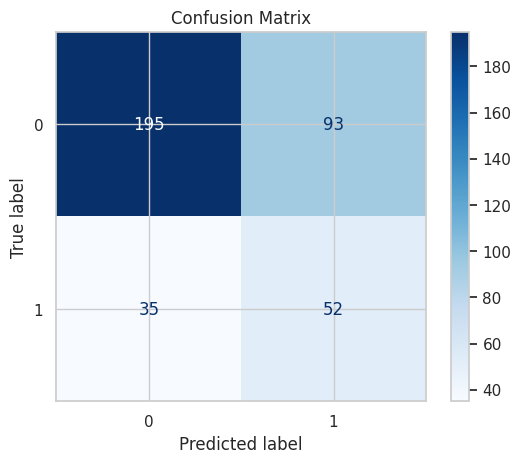

In [ ]:
#I will run on validation data for comparison sake
val_pred = log_reg_3.predict(X_val_raw_scaled)
print_metrics(y_val_raw, val_pred)

In [ ]:
#Save the results
store_model_results('Log_reg_3', 0.36, 0.60, 0.45, model_results)

In [ ]:
#confirming the dictionary
model_results

{'Log_reg_1': {'Precision': 0.39, 'Recall': 0.39, 'F1 Score': 0.39},
 'Log_reg_2': {'Precision': 0.33, 'Recall': 0.46, 'F1 Score': 0.38},
 'Log_reg_3': {'Precision': 0.36, 'Recall': 0.6, 'F1 Score': 0.45}}

## Decision Tree

- For the Decision Tree, I will create 2 models.
- One will be using just oversampled data and other one will be using the data that has been transformed.
- This will also act as a baseline model for non-linear models.

### Decision Tree 1

For this model, I will only use oversampled data.

#### Baseline Model

Accuracy: 0.948173005219985
-------
F1 Score: 0.9484230055658627
-------
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1341
           1       0.94      0.95      0.95      1341

    accuracy                           0.95      2682
   macro avg       0.95      0.95      0.95      2682
weighted avg       0.95      0.95      0.95      2682

-------
Confusion matrix (visualized below):


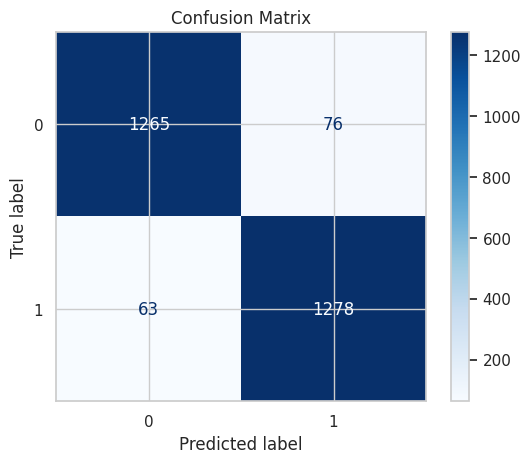

In [ ]:
# Fit and score a baseline DecisionTree Model
tree1 = DecisionTreeClassifier(random_state = 786)
tree1.fit(X_resampled, y_resampled)

train_predictions = tree1.predict(X_resampled)
print_metrics(y_resampled, train_predictions)

- As expected, the model has done too good to predict the training class and this can be a sign of overfitting rather than undestaing the pattern.
- Another thing it proves that our assumption of using non-linear models was correct as well. It is giving accuracy of 95% on the training data.
- I want to try its performance on the unseen data.

Accuracy: 0.6826666666666666
-------
F1 Score: 0.4251207729468599
-------
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       288
           1       0.37      0.51      0.43        87

    accuracy                           0.68       375
   macro avg       0.60      0.62      0.60       375
weighted avg       0.72      0.68      0.70       375

-------
Confusion matrix (visualized below):


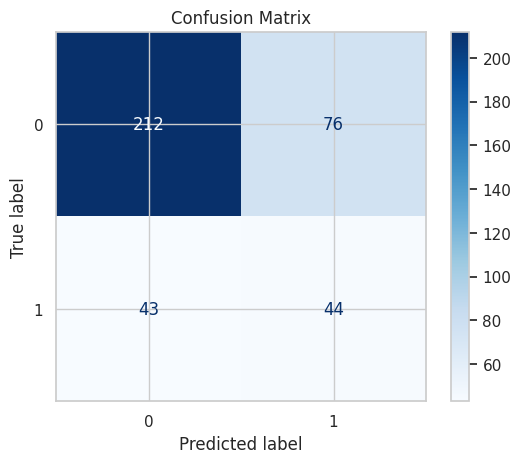

In [ ]:
#Validate
val_pred1 = tree1.predict(X_val_raw)
print_metrics(y_val_raw, val_pred1)

- As it can be seen that the accuracy and f1 score of the minority has decreased significantly.
- I want to try and tune the hyperparameters and see if there is any positive change in model's performance.
- This time round I will be using random search instead of grid search.

#### Hyperparameter Tuning Using Random Search

In [ ]:
t1_params = {'criterion': ['gini','entropy'],
          'max_features': [0.25, 0.75, 0.5, 1],
          'min_samples_split': [2,4,6,8],
          'min_samples_leaf': [1,2,4],
          'max_depth': [5,6,7,10],
          'random_state' : [786]
          }

# Set up cross-validation and scoring
cv = StratifiedKFold(n_splits=3)
scorer = make_scorer(f1_score, pos_label=1)

rand_tree1 = RandomizedSearchCV(tree1, t1_params, cv=cv, scoring=scorer,  n_jobs=-1)

rand_tree1.fit(X_resampled, y_resampled)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(random_state=786),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 6, 7, 10],
                                        'max_features': [0.25, 0.75, 0.5, 1],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6, 8],
                                        'random_state': [786]},
                   scoring=make_scorer(f1_score, response_method='predict', pos_label=1))

In [ ]:
# View best score and parameters
print('Best score:', rand_tree1.best_score_)
print('Best params:', rand_tree1.best_params_)

Best score: 0.7192014844435896
Best params: {'random_state': 786, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 10, 'criterion': 'gini'}


#### Evaluating Random Search Results

In [ ]:
results_df = pd.DataFrame(rand_tree1.cv_results_)
display(results_df[['param_criterion', 'param_min_samples_split', 'param_min_samples_leaf',
                  'param_max_features', 'param_max_depth', 'mean_test_score', 'std_test_score']]
      .sort_values(by='mean_test_score', ascending=False))

,param_criterion,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,mean_test_score,std_test_score
3,gini,4,2,0.500,10,0.719,0.083
9,entropy,4,1,0.500,7,0.716,0.063
2,entropy,8,1,0.750,7,0.708,0.085
7,entropy,6,1,0.250,10,0.701,0.081
4,gini,8,4,0.250,5,0.697,0.039
8,entropy,8,4,1.000,5,0.667,0.033
5,gini,2,2,1.000,6,0.666,0.033
0,entropy,2,4,1.000,6,0.665,0.032
1,entropy,4,1,1.000,6,0.663,0.031
6,entropy,4,4,1.000,10,0.657,0.026


- Using the logic explained before, I will be intersted in the hyperparameters that has good mean score but also has relatively low standard deviation.
- The best mean score is 0.73 but it has high standard deviation as well of 0.072.
- For me the best hyperparamets is row 7. This configuration has both a high mean score (0.657) and a very low standard deviation (0.026). While the mean score isn't the absolute best, its stability may make it a more reliable choice than configurations with higher mean scores but larger standard deviations.
- I will fit the model with this hyperparameters.

Accuracy: 0.825876211782252
-------
F1 Score: 0.8312251535959523
-------
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1341
           1       0.81      0.86      0.83      1341

    accuracy                           0.83      2682
   macro avg       0.83      0.83      0.83      2682
weighted avg       0.83      0.83      0.83      2682

-------
Confusion matrix (visualized below):


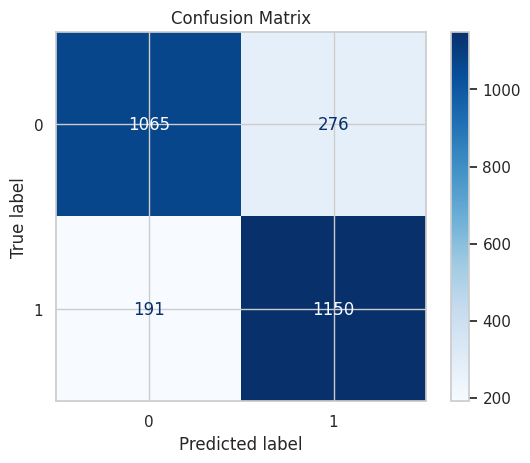

In [ ]:
rand_tree_model1 = DecisionTreeClassifier(
    criterion='entropy',
    min_samples_split=4,
    min_samples_leaf=4,
    max_features=1.0,
    max_depth=10,
    random_state=786
)

rand_tree_model1.fit(X_resampled, y_resampled)
y_pred_t1 = rand_tree_model1.predict(X_resampled)
print_metrics(y_resampled, y_pred_t1)

- The less accuracy shows that there is less signs of overfitting.
- I am also happy to see that it is predicting more accurately the minority since it has higher f1 score.
- I will try to run our best parameters on the validation set.

Accuracy: 0.6853333333333333
-------
F1 Score: 0.3979591836734694
-------
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       288
           1       0.36      0.45      0.40        87

    accuracy                           0.69       375
   macro avg       0.59      0.60      0.59       375
weighted avg       0.71      0.69      0.70       375

-------
Confusion matrix (visualized below):


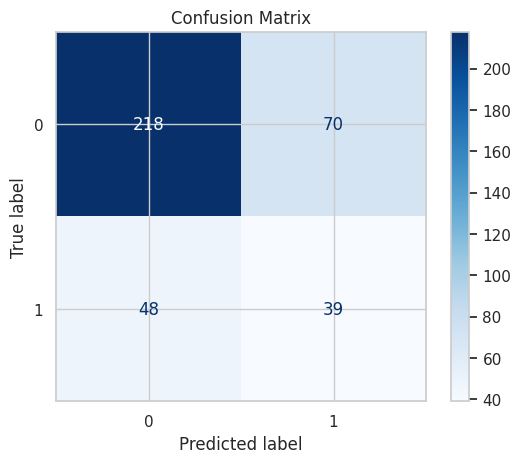

In [ ]:
#View validation metrics for the best model
y_pred_val_t1 = rand_tree_model1.predict(X_val_raw)
print_metrics(y_val_raw, y_pred_val_t1)

- The resutls are slightly worse than the model results we go above that did not tune any hyperparameters. Their it had f1 for minority as 0.43 and her we have 0.40.
- I still think that it can do slightly better if i did some manual tweaking on the random search results.
- To do this, I will  create a pipeline and do some manual tweaking and see if there is any better results.

#### Manual Tuning of the Hyperparameters

In [ ]:
#Create a pipeline for the best DecisionTree model

pipe_tree1 = Pipeline([('tree1', DecisionTreeClassifier(criterion='entropy',
                                                          max_depth=8,
                                                          max_features=0.75,
                                                          min_samples_split=5,
                                                          min_samples_leaf = 8,
                                                          random_state=786))
                        ])

pipe_tree1.fit(X_resampled, y_resampled)

Pipeline(steps=[('tree1',
                 DecisionTreeClassifier(criterion='entropy', max_depth=8,
                                        max_features=0.75, min_samples_leaf=8,
                                        min_samples_split=5,
                                        random_state=786))])

Accuracy: 0.7413333333333333
-------
F1 Score: 0.49214659685863876
-------
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.83       288
           1       0.45      0.54      0.49        87

    accuracy                           0.74       375
   macro avg       0.65      0.67      0.66       375
weighted avg       0.76      0.74      0.75       375

-------
Confusion matrix (visualized below):


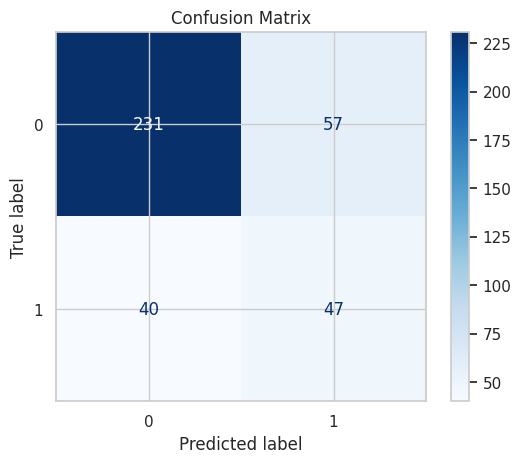

In [ ]:
# View metrics for validation data
y_pred_val_t1 = pipe_tree1.predict(X_val_raw)
print_metrics(y_val_raw, y_pred_val_t1)

- So, with some manual tweaking, I managed to improve the model's effeciency.
- The parameters that were returned by random search provided minority f1 score of 40% and overall accuracy of 69%.
- However, with manual tweaking, I achieved minority f1 score of 49% and overall accuracy of 74%.
- I am happy with this result as the logistic regression gave a nightmare result.

In [ ]:
#saving the result
store_model_results('D_Tree_1', 0.45, 0.54, 0.49, model_results)
#Confirming the results
model_results

{'Log_reg_1': {'Precision': 0.39, 'Recall': 0.39, 'F1 Score': 0.39},
 'Log_reg_2': {'Precision': 0.33, 'Recall': 0.46, 'F1 Score': 0.38},
 'Log_reg_3': {'Precision': 0.36, 'Recall': 0.6, 'F1 Score': 0.45},
 'D_Tree_1': {'Precision': 0.45, 'Recall': 0.54, 'F1 Score': 0.49}}

I will now try to run the decision tree on the transformed data. I want to see that if there is any improvement in the performance.

### Decision Tree 2

I will fit the baseline model and see how decision tree performs on the transformed data.

#### Baseline Model

In [ ]:
#Fitting and evaluating baseline Decision Tree
tree2 = DecisionTreeClassifier(random_state = 786)
tree2.fit(X_train_trans, y_train_res)

DecisionTreeClassifier(random_state=786)

Accuracy: 0.948173005219985
-------
F1 Score: 0.9484230055658627
-------
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1341
           1       0.94      0.95      0.95      1341

    accuracy                           0.95      2682
   macro avg       0.95      0.95      0.95      2682
weighted avg       0.95      0.95      0.95      2682

-------
Confusion matrix (visualized below):


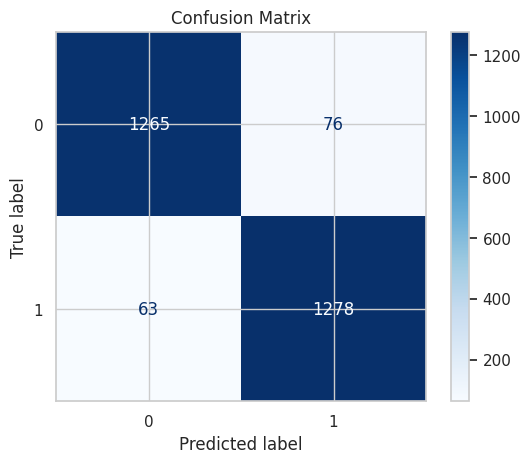

In [ ]:
#Evaluate
y_pred_t2 = tree2.predict(X_train_trans)
print_metrics(y_train_res, y_pred_t2)

The result is pretty similar to the last model and it does make sense because decision tree is logic based and not distance based so scaling or PCA should not have any impact.

Accuracy: 0.688
-------
F1 Score: 0.40609137055837563
-------
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       288
           1       0.36      0.46      0.41        87

    accuracy                           0.69       375
   macro avg       0.59      0.61      0.60       375
weighted avg       0.72      0.69      0.70       375

-------
Confusion matrix (visualized below):


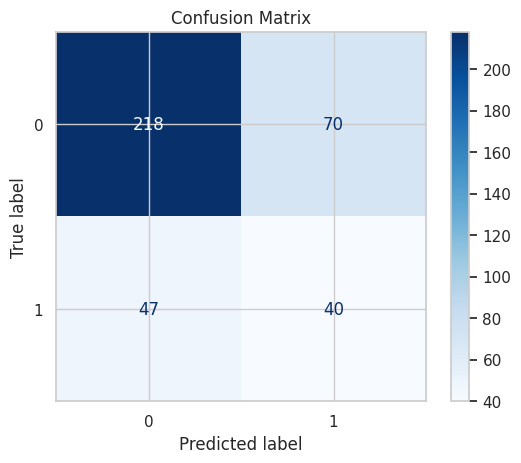

In [ ]:
#Validate
y_pred_val_t2 = tree2.predict(X_val_trans)
print_metrics(y_val, y_pred_val_t2)

- The f1 score for minority has reduced slightly.
- The differenc is not significant but I will still try and tune the hyperparameter and see if it can be better.

#### Hyperparameter Tuning using Random Search

In [ ]:
t2_params = {'criterion': ['gini','entropy'],
          'max_features': [0.25, 0.75, 0.5, 1],
          'min_samples_split': [2,4,6,8,10],
          'min_samples_leaf': [1,2,4,6,8],
          'max_depth': [5,6,7,9,10],
          'random_state' : [786]
          }

# Set up cross-validation and scoring
cv = StratifiedKFold(n_splits=5)
scorer = make_scorer(f1_score, pos_label=1)

rand_tree2 = RandomizedSearchCV(tree2, t2_params, cv=cv, scoring=scorer,  n_jobs=-1)

rand_tree2.fit(X_train_trans, y_train_res)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(random_state=786),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [5, 6, 7, 9, 10],
                                        'max_features': [0.25, 0.75, 0.5, 1],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 4, 6, 8, 10],
                                        'random_state': [786]},
                   scoring=make_scorer(f1_score, response_method='predict', pos_label=1))

In [ ]:
# View best score and parameters
print('Best score:', rand_tree2.best_score_)
print('Best params:', rand_tree2.best_params_)

Best score: 0.7401602413457085
Best params: {'random_state': 786, 'min_samples_split': 10, 'min_samples_leaf': 6, 'max_features': 0.25, 'max_depth': 10, 'criterion': 'gini'}


#### Evaluating Random Search Results

In [ ]:
#Evaluating random search full results
results_df = pd.DataFrame(rand_tree2.cv_results_)
display(results_df[['param_criterion', 'param_min_samples_split', 'param_min_samples_leaf',
                  'param_max_features', 'param_max_depth', 'mean_test_score', 'std_test_score']].sort_values(by='mean_test_score', ascending=False))

,param_criterion,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,mean_test_score,std_test_score
5,gini,10,6,0.250,10,0.740,0.127
1,gini,2,1,0.750,10,0.717,0.125
0,gini,10,2,0.250,7,0.711,0.108
8,entropy,6,2,1.000,10,0.710,0.127
7,entropy,4,4,0.500,10,0.709,0.137
9,entropy,2,1,0.500,6,0.709,0.121
4,gini,10,1,0.500,10,0.708,0.132
3,gini,10,1,0.750,9,0.708,0.119
2,gini,10,8,0.250,9,0.708,0.145
6,entropy,4,8,0.750,10,0.706,0.135


- Based on the same logic, the better parameters that can be obtained from the above reuslts is from row 7.
- In row 7, even though the mean has dropped slightly, the standard deviation is also relatively low.

Accuracy: 0.7874720357941835
-------
F1 Score: 0.7942238267148014
-------
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1341
           1       0.77      0.82      0.79      1341

    accuracy                           0.79      2682
   macro avg       0.79      0.79      0.79      2682
weighted avg       0.79      0.79      0.79      2682

-------
Confusion matrix (visualized below):


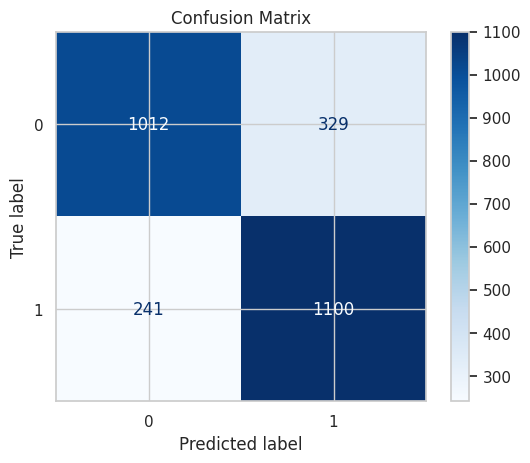

In [ ]:
rand_tree_model2 = DecisionTreeClassifier(
    criterion='entropy',
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=0.25,
    max_depth=7,
    random_state=786
)

rand_tree_model2.fit(X_train_trans, y_train_res)
y_pred_t2 = rand_tree_model2.predict(X_train_trans)
print_metrics(y_train_res, y_pred_t2)

Accuracy: 0.6533333333333333
-------
F1 Score: 0.336734693877551
-------
Classification report:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       288
           1       0.30      0.38      0.34        87

    accuracy                           0.65       375
   macro avg       0.55      0.56      0.55       375
weighted avg       0.68      0.65      0.67       375

-------
Confusion matrix (visualized below):


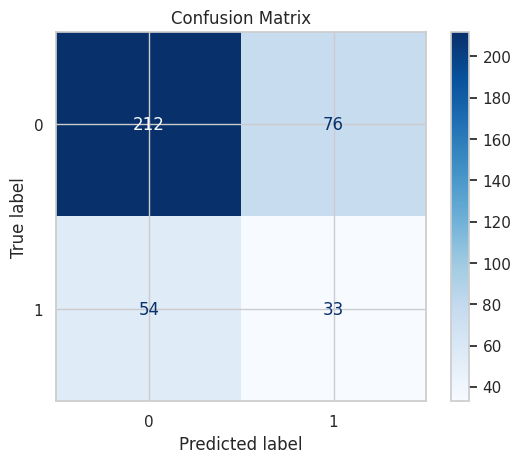

In [ ]:
# View the metrics for the best model on validation data
y_pred_val = rand_tree_model2.predict(X_val_trans)
print_metrics(y_val, y_pred_val)

- The random search results provided worse results than the normal parameters.
- However, I think that just like last time some manual tweaking will improve the results.
- So, I will fit it into a pipeline and do some manual tweaking to improve the models effeciency.

#### Manual Tuning of the Hyperparameters

In [ ]:
pipe_tree2 = Pipeline([('scaler', StandardScaler()),
                         ('pca', PCA(n_components=19)),
                         ('tree2', DecisionTreeClassifier(criterion='gini',
                                                          max_depth=9,
                                                          max_features=0.5,
                                                          min_samples_leaf=8,
                                                          min_samples_split=7,
                                                          random_state=786))
                        ])

pipe_tree2.fit(X_resampled, y_resampled)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=19)),
                ('tree2',
                 DecisionTreeClassifier(max_depth=9, max_features=0.5,
                                        min_samples_leaf=8, min_samples_split=7,
                                        random_state=786))])

Accuracy: 0.6906666666666667
-------
F1 Score: 0.3894736842105263
-------
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       288
           1       0.36      0.43      0.39        87

    accuracy                           0.69       375
   macro avg       0.59      0.60      0.59       375
weighted avg       0.71      0.69      0.70       375

-------
Confusion matrix (visualized below):


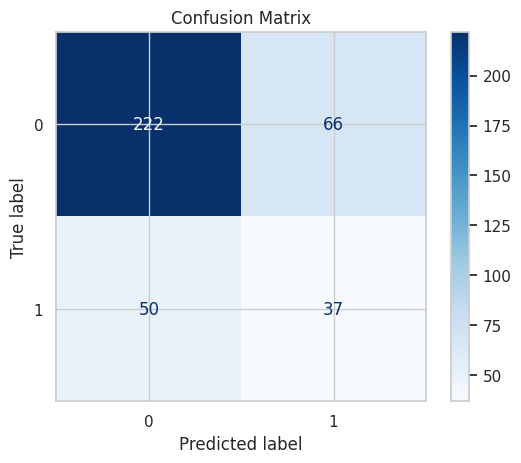

In [ ]:
# View the metrics for the best model
y_pred_val = pipe_tree2.predict(X_val)
print_metrics(y_val, y_pred_val)

- I tried my best but there was very small improvement after manual tweaking.
- I am aware that since the data is transformed uying pCA, max_features are not really required to tune but without that hyperparameter the results were worse.
- I will leave this model as it is because I really do not think that it will get any better.
- I will try to use a slightly advanced version of decision tree that is random forest to create the models and see if it works any better.
- Just a reminder, so far my best model was Decision Tree 1 with minority f1 of 49%.
- My aim for the upcoming models is to get better f1 than that.

In [ ]:
#Save the results
store_model_results('D_Tree_2', 0.36, 0.43, 0.39, model_results)
#Confirming the results
model_results

{'Log_reg_1': {'Precision': 0.39, 'Recall': 0.39, 'F1 Score': 0.39},
 'Log_reg_2': {'Precision': 0.33, 'Recall': 0.46, 'F1 Score': 0.38},
 'Log_reg_3': {'Precision': 0.36, 'Recall': 0.6, 'F1 Score': 0.45},
 'D_Tree_1': {'Precision': 0.45, 'Recall': 0.54, 'F1 Score': 0.49},
 'D_Tree_2': {'Precision': 0.36, 'Recall': 0.43, 'F1 Score': 0.39}}

## Random Forest

- For the Random Forest, I will be creating 3 models.
- One will be with just oversampled data, one will be with transformed data, and last one will be using the class_weight.
- Comparing these approaches helps determine which method improves performance (accuracy, recall, F1-score) on the minority class and the overall model.

### Random Forest 1

#### Baseline Model

- This model will use the data that has just been class balanced but not transformed.
- As usual I will instantiate the classifier, fit the training data and look at the results to see if it is overfitting or not.

Accuracy: 0.948173005219985
-------
F1 Score: 0.948878264067672
-------
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1341
           1       0.94      0.96      0.95      1341

    accuracy                           0.95      2682
   macro avg       0.95      0.95      0.95      2682
weighted avg       0.95      0.95      0.95      2682

-------
Confusion matrix (visualized below):


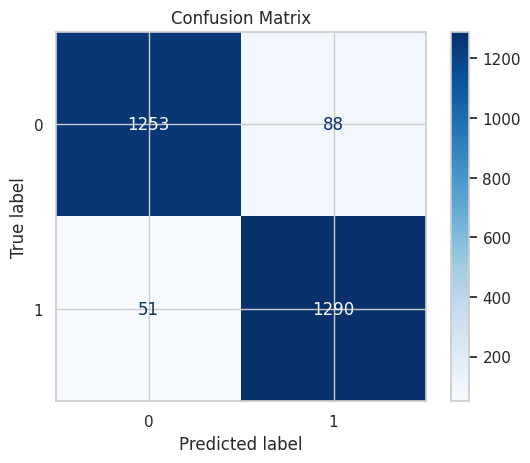

In [ ]:
# Fit and score a baseline RandomForestClassifier
forest1 = RandomForestClassifier(random_state = 786)
forest1.fit(X_resampled, y_resampled)

train_pred = forest1.predict(X_resampled)

print_metrics(y_resampled, train_pred)

- By looking at the results, we can see that it is overfitting on the training data.

Accuracy: 0.7546666666666667
-------
F1 Score: 0.43209876543209874
-------
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       288
           1       0.47      0.40      0.43        87

    accuracy                           0.75       375
   macro avg       0.65      0.63      0.64       375
weighted avg       0.74      0.75      0.75       375

-------
Confusion matrix (visualized below):


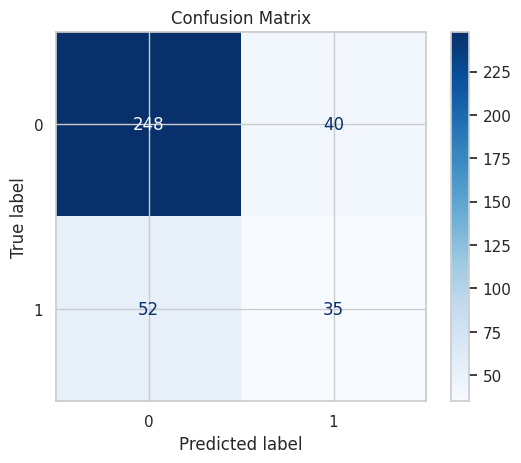

In [ ]:
#I will just try to see that model's accuracy on the raw data that has not been oversampled yet.
val_pred = forest1.predict(X_val_raw)
print_metrics(y_val_raw, val_pred)

- Now I can see the reality of the model's accuracy.
- The accuracy has dropped significantly but as mentioned before I am more interestred in minority f1 score which too has dropped.
- I will try to use random search and see if there is any improvement in the model's performance but before I do that I want to see which features highly contribute in our model using the raw data.

#### Feature Importance - Raw Data

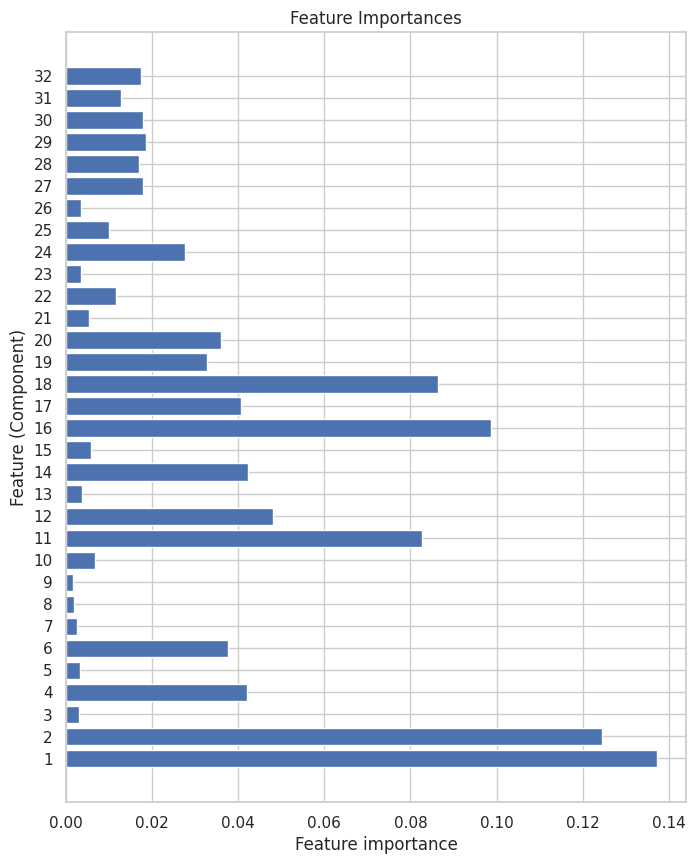

In [ ]:
# Visualize feature importances using original features
plot_feature_importances(forest1, X_train_raw)

There are few points which I could deduce from the feature importance graph:

- The first 2 features dominates the graph. These 2 feattures have significantly higher importance compared to others and it makes sense because this 2 features are the average x and y position of the cursor.

- The raw data's feature importance is concentrated heavily on a few features, with most features being negligible.

- There is sign of non-linearity in the data.

- In the next model, I will do the feature importance with the transformed data and see the difference in the feature importance.

#### Hyperparameter Tuning Using Random Search

In [ ]:
# Use GridSearchCV to find best parameters for the Random Forest
params = {'n_estimators': randint(50, 200),
          'max_features': range(12,22),
          'min_samples_split': randint(2, 10),
          'min_samples_leaf': randint(1, 10),
          'max_depth': randint(1, 50),
          'random_state' : [786]
          }

# Set up cross-validation and scoring
cv = StratifiedKFold(n_splits=3)
scorer = make_scorer(f1_score, pos_label=1)

rand_forest1 = RandomizedSearchCV(forest1, params, cv=cv, scoring=scorer,  n_jobs=-1)

rand_forest1.fit(X_resampled, y_resampled)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(random_state=786),
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7aa853bb04c0>,
                                        'max_features': range(12, 22),
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7aa86a56d570>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7aa862b632e0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7aa87c7eb160>,
                                        'random_state': [786]},
                   scoring=make_scorer(f1_score, response_method='predict', pos_label=1))

In [ ]:
# View best score and parameters
print('Best score:', rand_forest1.best_score_)
print('Best params:', rand_forest1.best_params_)

Best score: 0.7593901593901594
Best params: {'max_depth': 16, 'max_features': 21, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 121, 'random_state': 786}


#### Evaluating Random Search Results

In [ ]:
#Evaluating full random search results
results_df = pd.DataFrame(rand_forest1.cv_results_)
display(results_df[['param_n_estimators', 'param_max_features', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_depth', 'mean_test_score', 'std_test_score']].sort_values(by='mean_test_score', ascending=False))

,param_n_estimators,param_max_features,param_min_samples_split,param_min_samples_leaf,param_max_depth,mean_test_score,std_test_score
8,121,21,4,1,16,0.759,0.124
1,191,17,5,2,15,0.753,0.123
2,78,12,8,2,24,0.751,0.140
5,85,17,8,2,23,0.746,0.144
7,169,17,5,4,32,0.742,0.131
3,116,21,7,9,34,0.740,0.108
6,103,15,8,6,41,0.740,0.126
0,108,18,5,8,28,0.739,0.113
4,178,16,9,7,21,0.739,0.120
9,146,12,5,7,10,0.737,0.110


- As per the results above, the best hyperparameters that provides similar mean test score but also provide significantly low standard deviation is from row 7.
- This shows consistent performance across different data splits.
- I will try to fit this hyperparameters and check the performance on the validation data.

Accuracy: 0.648
-------
F1 Score: 0.44537815126050423
-------
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.66      0.74       288
           1       0.35      0.61      0.45        87

    accuracy                           0.65       375
   macro avg       0.60      0.63      0.59       375
weighted avg       0.73      0.65      0.67       375

-------
Confusion matrix (visualized below):


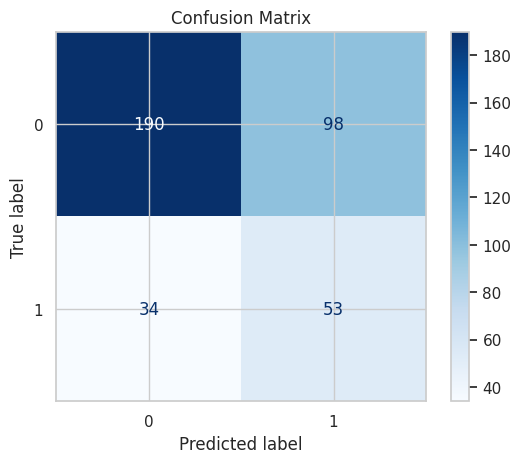

In [ ]:
#Train model with the above chosen hyperparameters
rand_forest_model1 = RandomForestClassifier(
    max_depth=4,
    max_features=12,
    min_samples_leaf=7,
    min_samples_split=2,
    n_estimators=170,
    random_state=786)

rand_forest_model1.fit(X_resampled, y_resampled)
y_pred = rand_forest_model1.predict(X_val_raw)
print_metrics(y_val_raw, y_pred)

- The optimised Random Forest scored F1 score of 45% on the validation set.
- This is 4% lower than the best score we got on decision tree which was 49%.
- Just as before, I will try to see if any manual altering can improve the effeciency of the model and to do that I will create a pipeline.

#### Manual Tuning of the Hyperparameters

In [ ]:
# Create and fit the model pipeline
pipe_forest1 = Pipeline([('forest1', RandomForestClassifier(max_depth=6,
                                                            max_features=12,
                                                            n_estimators=140,
                                                            min_samples_split=2,
                                                            min_samples_leaf=7,
                                                            random_state=786))
                        ])

pipe_forest1.fit(X_resampled, y_resampled)

Pipeline(steps=[('forest1',
                 RandomForestClassifier(max_depth=6, max_features=12,
                                        min_samples_leaf=7, n_estimators=140,
                                        random_state=786))])

Accuracy: 0.7013333333333334
-------
F1 Score: 0.48148148148148145
-------
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       288
           1       0.40      0.60      0.48        87

    accuracy                           0.70       375
   macro avg       0.63      0.67      0.64       375
weighted avg       0.75      0.70      0.72       375

-------
Confusion matrix (visualized below):


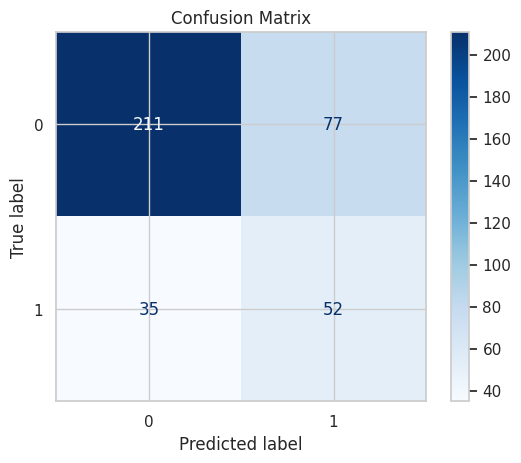

In [ ]:
# View metrics for validation data
y_pred = pipe_forest1.predict(X_val_raw)
print_metrics(y_val_raw, y_pred)

- With the help of manually tweaking the random search result but still being in the same search space, I managed to make it provide similar result as our best decision tree model which is getting minority f1 of 48%.
- However, I am still not satisfied because random forest should provide a better result as it is more advacned than decision tree.
- Next model, I will try to use the processed data and see if we can improve the performance.

In [ ]:
#save the results
store_model_results('Rand_Forest_1', 0.40, 0.60, 0.48, model_results)
#Confirming the results
model_results

{'Log_reg_1': {'Precision': 0.39, 'Recall': 0.39, 'F1 Score': 0.39},
 'Log_reg_2': {'Precision': 0.33, 'Recall': 0.46, 'F1 Score': 0.38},
 'Log_reg_3': {'Precision': 0.36, 'Recall': 0.6, 'F1 Score': 0.45},
 'D_Tree_1': {'Precision': 0.45, 'Recall': 0.54, 'F1 Score': 0.49},
 'D_Tree_2': {'Precision': 0.36, 'Recall': 0.43, 'F1 Score': 0.39},
 'Rand_Forest_1': {'Precision': 0.4, 'Recall': 0.6, 'F1 Score': 0.48}}

### Random Forest 2

This model will use processed data.

#### Baseline Model

In [ ]:
# Fit and score a baseline RandomForestClassifier
forest2 = RandomForestClassifier(random_state = 786)
forest2.fit(X_train_trans, y_train_res)

RandomForestClassifier(random_state=786)

Accuracy: 0.948173005219985
-------
F1 Score: 0.9487274068609369
-------
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1341
           1       0.94      0.96      0.95      1341

    accuracy                           0.95      2682
   macro avg       0.95      0.95      0.95      2682
weighted avg       0.95      0.95      0.95      2682

-------
Confusion matrix (visualized below):


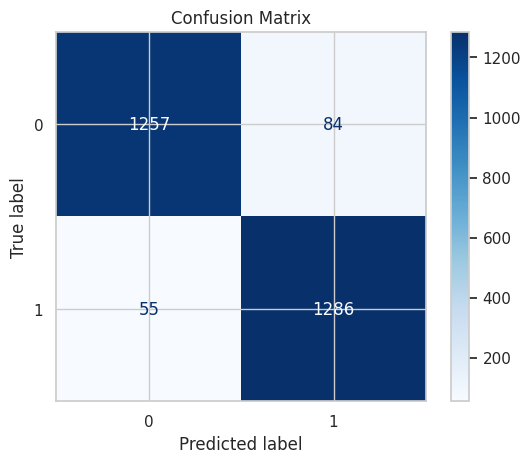

In [ ]:
# Evaluate
y_pred = forest2.predict(X_train_trans)
print_metrics(y_train_res, y_pred)

This was no surprise because random forest also uses similar logic as decision tree so the processed data does not really interfere with the results.

Accuracy: 0.736
-------
F1 Score: 0.38509316770186336
-------
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       288
           1       0.42      0.36      0.39        87

    accuracy                           0.74       375
   macro avg       0.62      0.60      0.61       375
weighted avg       0.72      0.74      0.73       375

-------
Confusion matrix (visualized below):


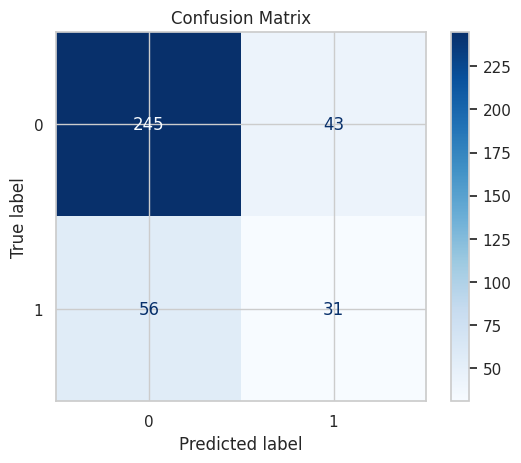

In [ ]:
# Validate
y_pred = forest2.predict(X_val_trans)
print_metrics(y_val, y_pred)

- Atleast I know that the model is safe from overfititng because in the training data it had accuracy of 95% but in the validation data it has accuracy of 74%.
- However, the minority f1 score is pretty bad and I am not really satisfied.
- For now, I want to check the feature importance and see what information we can extract.

#### Feature Importance - Transformed Data

In [ ]:
# Check the feature importances
forest2.feature_importances_

array([0.04687315, 0.04372633, 0.09762639, 0.08069295, 0.03754747,
       0.0558374 , 0.05065333, 0.05718821, 0.0466513 , 0.03814338,
       0.04518095, 0.07147001, 0.06046173, 0.05214626, 0.05732313,
       0.05316605, 0.03166949, 0.03930585, 0.03433661])

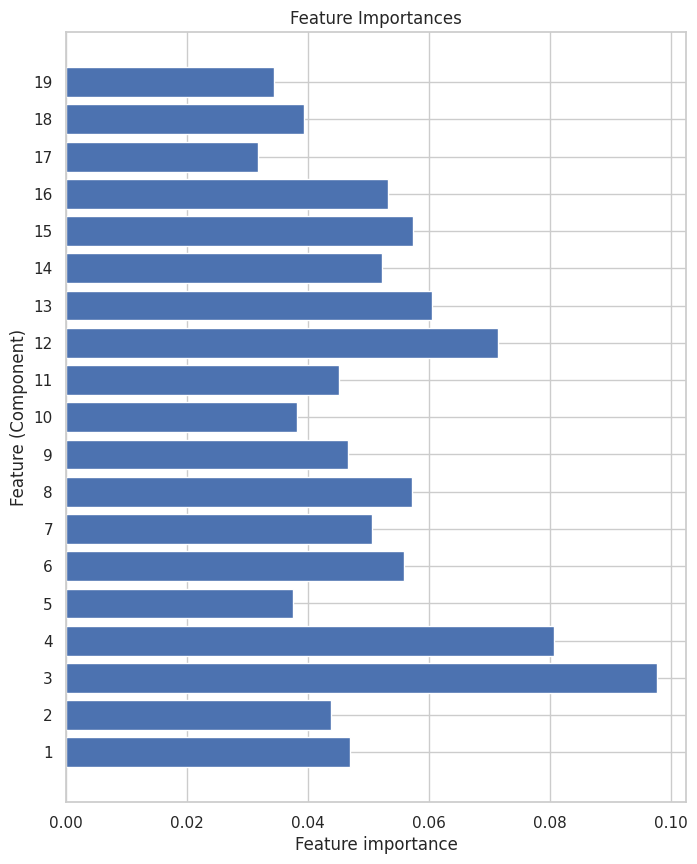

In [ ]:
# Visualize feature importances
plot_feature_importances(forest2, X_train_trans)

From the feature importance graph, I can extract few key information:
- PC3 is the most important feature in the data. This means that it captures very important aspect of the data that strongly influences the outcome. In most cases, PC1 explains the most variance but since it is PC3 in my case it means that there is specific pattern in PC3 that is significant to the problem.

- As mentioned, usually the PCs that should show the highest varaince, PC1 & PC2, have much lower feature importance. This means that variance alone is not enough to explain the outcome but the task requires to focus on features that are less dominant but more targeted such PC3 & PC4.

- The next important PC after PC4 is direct PC12. Instead of dropping linearly from PC1 onwards it has an uneven trend. This confirms the non-linear nature of the data as proved in the EDA.

Difference between feature importance (F.I) between raw and transformed data:
- In the raw data F.I, PC1 & PC2 dominated but in the PCA F.I shifts to specific PC's like PC3 & PC4 which are combination of multiple raw features. This shift shows how PCA distributes importance across components rather than concentrating on single features.

- Raw feature importance is more interpretable because it directly ties to specific features (e.g., Feature 1 and 2). In contrast, PCA requires connecting the PCs back to the raw features to fully understand their importance.

- The raw data graph helps identify the individual raw features that are most predictive, while the PCA graph highlights how combinations of features (via PCs) can explain the outcomes better in complex, non-linear scenarios.

By analysing both set of data, it easier to understnad which raw features are important and how combination of features interact.

#### Hyperparameter Tuning Using Random Search

Getting back to the model, I want to run a random search and see if I can get any improvement in the model performance.

In [ ]:
# Use GridSearchCV to find best parameters for the Random Forest
params = {'n_estimators': randint(50, 200),
          'max_features': range(12,22),
          'min_samples_split': randint(2, 10),
          'min_samples_leaf': randint(1, 10),
          'max_depth': randint(1, 50),
          'random_state' : [786]
          }

# Set up cross-validation and scoring
cv = StratifiedKFold(n_splits=3)
scorer = make_scorer(f1_score, pos_label=1)

rand_forest2 = RandomizedSearchCV(forest2, params, cv=cv, scoring=scorer,  n_jobs=-1)

rand_forest2.fit(X_train_trans, y_train_res)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(random_state=786),
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7aa853b70ac0>,
                                        'max_features': range(12, 22),
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7aa853b72800>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7aa853b71900>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7aa8628be9e0>,
                                        'random_state': [786]},
                   scoring=make_scorer(f1_score, response_method='predict', pos_label=1))

In [ ]:
# View best score and parameters
print('Best score:', rand_forest2.best_score_)
print('Best params:', rand_forest2.best_params_)

Best score: 0.7265776949527503
Best params: {'max_depth': 32, 'max_features': 14, 'min_samples_leaf': 8, 'min_samples_split': 3, 'n_estimators': 173, 'random_state': 786}


#### Evaluating Random Search Results

In [ ]:
#evaluating random search results
results_df = pd.DataFrame(rand_forest2.cv_results_)
display(results_df[['param_n_estimators', 'param_max_features', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_depth', 'mean_test_score', 'std_test_score']].sort_values(by='mean_test_score', ascending=False))

,param_n_estimators,param_max_features,param_min_samples_split,param_min_samples_leaf,param_max_depth,mean_test_score,std_test_score
3,173,14,3,8,32,0.727,0.185
0,128,13,3,5,18,0.722,0.180
7,59,15,6,4,33,0.722,0.179
1,189,19,2,2,15,0.721,0.181
9,133,20,8,2,39,0.721,0.180
4,198,16,4,8,26,0.721,0.181
5,184,17,5,3,40,0.720,0.182
8,147,18,9,4,49,0.719,0.180
2,163,20,3,9,39,0.719,0.182
6,111,16,3,9,20,0.719,0.178


- The better parameters from the results are the ones that have almost similar mean test score but relatively low standard deviation.
- That is row 1 with mean score of 0.725 and standard deviation of 0.164.
- I will be choosing that to fit my model and evaluate.

Accuracy: 0.6693333333333333
-------
F1 Score: 0.3333333333333333
-------
Classification report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       288
           1       0.31      0.36      0.33        87

    accuracy                           0.67       375
   macro avg       0.56      0.56      0.56       375
weighted avg       0.68      0.67      0.68       375

-------
Confusion matrix (visualized below):


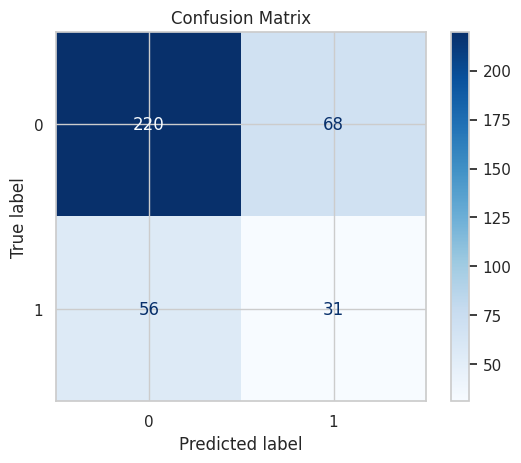

In [ ]:
#viewing the validation metric with the above hyperparameters
rand_forest_model2 = RandomForestClassifier(
    max_depth=8,
    max_features=20,
    min_samples_leaf=2,
    min_samples_split=7,
    n_estimators=159,
    random_state=786)

rand_forest_model1.fit(X_train_trans, y_train_res)
y_pred = rand_forest_model1.predict(X_val_trans)
print_metrics(y_val, y_pred)

- There is a negative difference in the minority f1 score.
- Before tuning, the f1 score was 39% and after tuning it became 33%.
- I will try to do some manual tweaking and see if there is any better performing hyperparameters.

#### Manual Tuning of the Hyperparameters

In [ ]:
# Construct a pipeline for the best Random Forest model
pipe_forest2 = Pipeline([('scaler', StandardScaler()),
                         ('pca', PCA(n_components=19)),
                         ('forest2', RandomForestClassifier(max_depth=8,
                                                            max_features = 19,
                                                            min_samples_leaf=2,
                                                            min_samples_split=7,
                                                            n_estimators=159,
                                                            random_state=786))
                        ])
pipe_forest2.fit(X_resampled, y_resampled)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=19)),
                ('forest2',
                 RandomForestClassifier(max_depth=8, max_features=19,
                                        min_samples_leaf=2, min_samples_split=7,
                                        n_estimators=159, random_state=786))])

Accuracy: 0.7306666666666667
-------
F1 Score: 0.39520958083832336
-------
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       288
           1       0.41      0.38      0.40        87

    accuracy                           0.73       375
   macro avg       0.61      0.61      0.61       375
weighted avg       0.72      0.73      0.73       375

-------
Confusion matrix (visualized below):


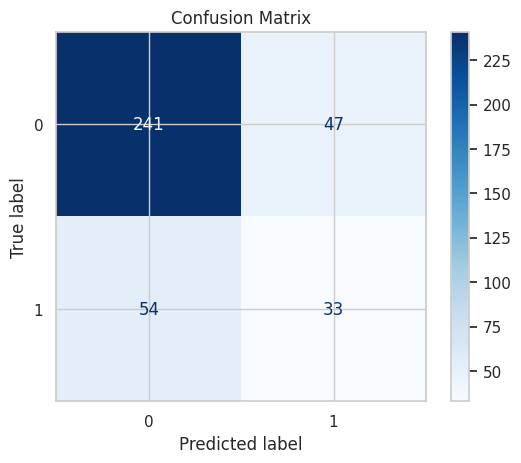

In [ ]:
# View the metrics for the best model
y_pred = pipe_forest2.predict(X_val)
print_metrics(y_val, y_pred)

- With just slghtly tweaking but within the same search space, I managed to make it upto 40%.
- I do not think also that it will get better than this so I will stop tuning here. However, I still want to try this model using the data that has been balanced using class weight and see if it does any magic.

In [ ]:
#save the results
store_model_results('Rand_Forest_2', 0.41, 0.38, 0.40, model_results)
#Confirming the results
model_results

{'Log_reg_1': {'Precision': 0.39, 'Recall': 0.39, 'F1 Score': 0.39},
 'Log_reg_2': {'Precision': 0.33, 'Recall': 0.46, 'F1 Score': 0.38},
 'Log_reg_3': {'Precision': 0.36, 'Recall': 0.6, 'F1 Score': 0.45},
 'D_Tree_1': {'Precision': 0.45, 'Recall': 0.54, 'F1 Score': 0.49},
 'D_Tree_2': {'Precision': 0.36, 'Recall': 0.43, 'F1 Score': 0.39},
 'Rand_Forest_1': {'Precision': 0.4, 'Recall': 0.6, 'F1 Score': 0.48},
 'Rand_Forest_2': {'Precision': 0.41, 'Recall': 0.38, 'F1 Score': 0.4}}

### Random Forest 3

AS mentioned above, I will use the class weight option in this model

Accuracy: 0.9228571428571428
-------
F1 Score: 0.8511576626240352
-------
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1341
           1       0.78      0.94      0.85       409

    accuracy                           0.92      1750
   macro avg       0.88      0.93      0.90      1750
weighted avg       0.93      0.92      0.93      1750

-------
Confusion matrix (visualized below):


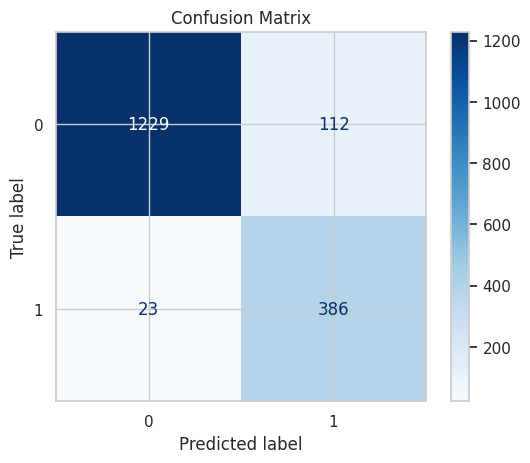

In [ ]:
forest3 = RandomForestClassifier(class_weight = 'balanced', random_state = 786)
forest3.fit(X_raw_scaled, y_train_raw)

train_pred = forest3.predict(X_raw_scaled)
print_metrics(y_train_raw, train_pred)

Accuracy: 0.7546666666666667
-------
F1 Score: 0.352112676056338
-------
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       288
           1       0.45      0.29      0.35        87

    accuracy                           0.75       375
   macro avg       0.63      0.59      0.60       375
weighted avg       0.72      0.75      0.73       375

-------
Confusion matrix (visualized below):


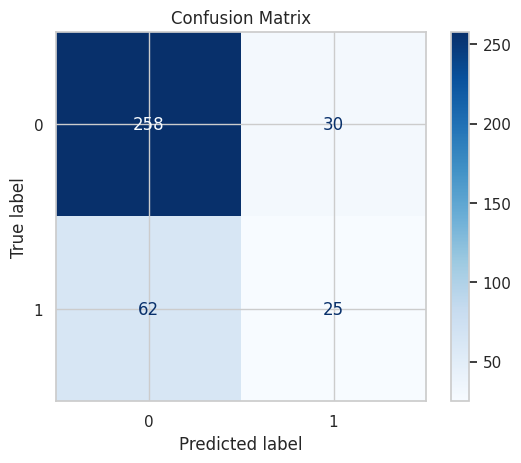

In [ ]:
# Validate
y_pred = forest3.predict(X_val_raw_scaled)
print_metrics(y_val_raw, y_pred)

- The data using class_weight option does not really show any improvement unstead the minority f1 score have declined by 4%.
- I think so that using oversampled data is best for our data because, class weight option is only showing negative impact.

In [ ]:
#save the results
store_model_results('Rand_Forest_3', 0.45, 0.29, 0.35, model_results)
#Confirming the results
model_results

{'Log_reg_1': {'Precision': 0.39, 'Recall': 0.39, 'F1 Score': 0.39},
 'Log_reg_2': {'Precision': 0.33, 'Recall': 0.46, 'F1 Score': 0.38},
 'Log_reg_3': {'Precision': 0.36, 'Recall': 0.6, 'F1 Score': 0.45},
 'D_Tree_1': {'Precision': 0.45, 'Recall': 0.54, 'F1 Score': 0.49},
 'D_Tree_2': {'Precision': 0.36, 'Recall': 0.43, 'F1 Score': 0.39},
 'Rand_Forest_1': {'Precision': 0.4, 'Recall': 0.6, 'F1 Score': 0.48},
 'Rand_Forest_2': {'Precision': 0.41, 'Recall': 0.38, 'F1 Score': 0.4},
 'Rand_Forest_3': {'Precision': 0.45, 'Recall': 0.29, 'F1 Score': 0.35}}

## XG-Boost

**XGBoost** is an ensemble method that trains a series of weak learners to work in sequence to predict labels. This is typically considered a more flexible and powerful type of algorithm than a Random Forest.Ensemble methods are known to be very powerful for classification tasks. Let us see if it lives upto the hype.
- I will be training 2 models, one with the oversampled data and one with the transformed data.

### XG-Boost 1

I will be training theis model on the balanced data.

#### Model

Accuracy: 0.9295302013422819
-------
F1 Score: 0.9307945807396558
-------
Classification report:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      1341
           1       0.91      0.95      0.93      1341

    accuracy                           0.93      2682
   macro avg       0.93      0.93      0.93      2682
weighted avg       0.93      0.93      0.93      2682

-------
Confusion matrix (visualized below):


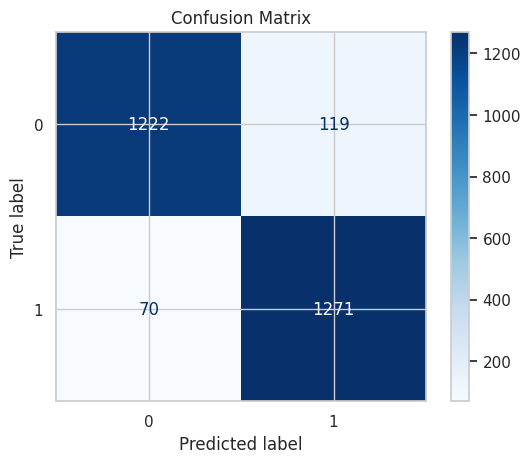

In [ ]:
xg = xgb.XGBClassifier(random_state = 786)
xg.fit(X_resampled, y_resampled)

train_pred = xg.predict(X_resampled)

print_metrics(y_resampled, train_pred)

Accuracy: 0.7386666666666667
-------
F1 Score: 0.4431818181818182
-------
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       288
           1       0.44      0.45      0.44        87

    accuracy                           0.74       375
   macro avg       0.64      0.64      0.64       375
weighted avg       0.74      0.74      0.74       375

-------
Confusion matrix (visualized below):


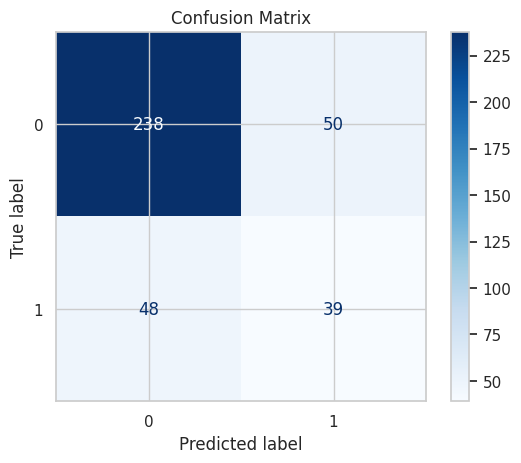

In [ ]:
# Validate
val_pred = xg.predict(X_val_raw)

print_metrics(y_val_raw, val_pred)

- The result is not as good as what we got from best random forest.
- I will try to run a random search and see if I can make it more effecient.

#### Hyperparameter Tuning Using Random Search

In [ ]:
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
}

# Set up cross-validation and scoring
cv = StratifiedKFold(n_splits=5)
scorer = make_scorer(f1_score, pos_label=1)

rand_xg = RandomizedSearchCV(
    estimator=xg,
    param_distributions=param_distributions,
    n_iter=50,
    scoring=scorer,
    cv=cv,
    verbose=2,
    random_state=786,
    n_jobs=-1
)

# Step 6: Perform the random search
rand_xg.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           impor...
                                           num_parallel_tree=None,
                                           random_state=786, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=786,
                   scoring=make_scorer(f1_score, response_method='predict', pos_label=1),
                   verbose=2)

In [ ]:
# View best score and parameters
print('Best score:', rand_xg.best_score_)
print('Best params:', rand_xg.best_params_)

Best score: 0.7933336252603866
Best params: {'subsample': 0.6, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.2, 'colsample_bytree': 0.8}


#### Evaluating Random Search Results

In [ ]:
#evaluating random search full results
results_df = pd.DataFrame(rand_xg.cv_results_)
display(results_df[['param_n_estimators', 'param_max_depth', 'param_learning_rate', 'param_subsample', 'param_colsample_bytree', 'param_gamma', 'mean_test_score', 'std_test_score']].sort_values(by='mean_test_score', ascending=False))

,param_n_estimators,param_max_depth,param_learning_rate,param_subsample,param_colsample_bytree,param_gamma,mean_test_score,std_test_score
24,100,10,0.200,0.600,0.800,0.200,0.793,0.127
9,300,7,0.100,0.800,1.000,0.300,0.792,0.141
44,300,7,0.050,0.800,0.600,0.200,0.792,0.142
47,100,7,0.200,0.800,0.600,0.000,0.790,0.136
34,100,10,0.100,0.800,0.800,0.100,0.788,0.146
15,200,5,0.200,1.000,0.800,0.100,0.788,0.141
13,50,7,0.200,0.800,0.800,0.200,0.786,0.133
11,300,5,0.050,0.600,0.800,0.100,0.786,0.137
38,100,7,0.100,0.800,0.800,0.200,0.785,0.138
16,100,7,0.200,0.600,0.600,0.000,0.785,0.129


From the results above I can say that:
- Best Performer is row 24 offers the highest mean test score(0.793), although it has higher variability (0.127).
- Most Stable is Row 7 offers the lowest variability (0.095) with a slightly lower mean test score(0.770).
- Lowest performer is row 48 shows the lowest mean test score (0.721) but with very low variability(0.054).

A balanced choice for me is not the best performed but more stable performed which is row 1:
- Mean Test Score - 0.77 (which is just slightly lower than top performer)
- Standard Deviaition - 0.095 (relatively much lower)
- This row offers a good mean test score with moderate variability which makes it a balanced choice because for this model I want more stability so it can be generalised well.


Accuracy: 0.7333333333333333
-------
F1 Score: 0.4791666666666667
-------
Classification report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       288
           1       0.44      0.53      0.48        87

    accuracy                           0.73       375
   macro avg       0.64      0.66      0.65       375
weighted avg       0.75      0.73      0.74       375

-------
Confusion matrix (visualized below):


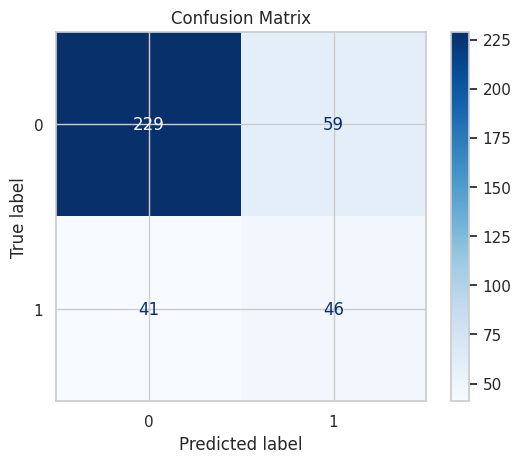

In [ ]:
#create xgb model using the above chose hyperparameters
xgb_model_11 = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.01,
    subsample=0.6,
    colsample_bytree=1.0,
    gamma=0.2,
    objective='binary:logistic',
    random_state=786
)

xgb_model_11.fit(X_resampled, y_resampled)
y_pred = xgb_model_11.predict(X_val_raw)
print_metrics(y_val_raw, y_pred)

- Even after tuning the hyperparameter, the result is lower than the one we got in random forest.
- I will try to do some manual tweaking and see if it produces any better results.

#### Manual Tuning of the Hyperparameters

In [ ]:
# Build the optimized model after slight tweaking
xgb_best = xgb.XGBClassifier(gamma=0.2, learning_rate=0.01, n_estimators=100,
                             subsample=0.7, max_depth = 8, colsample_bytree = 0.8 ,random_state = 786)
xgb_best.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=786, ...)

Accuracy: 0.736
-------
F1 Score: 0.49746192893401014
-------
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       288
           1       0.45      0.56      0.50        87

    accuracy                           0.74       375
   macro avg       0.65      0.68      0.66       375
weighted avg       0.76      0.74      0.75       375

-------
Confusion matrix (visualized below):


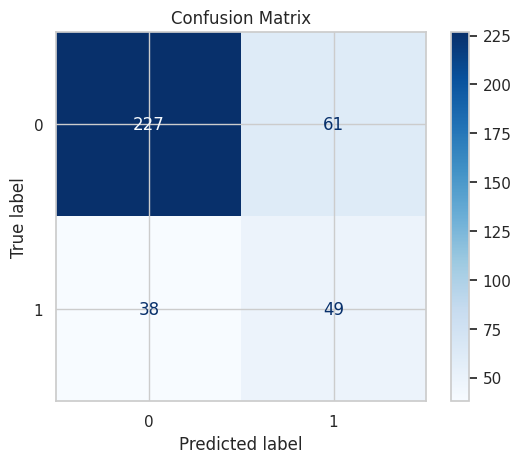

In [ ]:
# View metrics for validation data
y_pred = xgb_best.predict(X_val_raw)
print_metrics(y_val_raw, y_pred)

- With some tweaking within the same search space, I managed to improve the models results to 50%.
- There is no significant difference then the one we got from best random  forest which was 49%.
- However, I am still happy that we atleast reached half way mark.
- I will try to use the processed data and see how it works with that but I have less hopes because unitl now the oversamples data has perfromed better in every model than the processed data.

In [ ]:
#save the results
store_model_results('XGB_1', 0.45, 0.56, 0.50, model_results)
#Confirming the results
model_results

{'Log_reg_1': {'Precision': 0.39, 'Recall': 0.39, 'F1 Score': 0.39},
 'Log_reg_2': {'Precision': 0.33, 'Recall': 0.46, 'F1 Score': 0.38},
 'Log_reg_3': {'Precision': 0.36, 'Recall': 0.6, 'F1 Score': 0.45},
 'D_Tree_1': {'Precision': 0.45, 'Recall': 0.54, 'F1 Score': 0.49},
 'D_Tree_2': {'Precision': 0.36, 'Recall': 0.43, 'F1 Score': 0.39},
 'Rand_Forest_1': {'Precision': 0.4, 'Recall': 0.6, 'F1 Score': 0.48},
 'Rand_Forest_2': {'Precision': 0.41, 'Recall': 0.38, 'F1 Score': 0.4},
 'Rand_Forest_3': {'Precision': 0.45, 'Recall': 0.29, 'F1 Score': 0.35},
 'XGB_1': {'Precision': 0.45, 'Recall': 0.56, 'F1 Score': 0.5}}

### XG-Boost 2

- This model will use the transformed data.
- I will be repeating same process to get the best results so I will not explain again.

#### Model

Accuracy: 0.948173005219985
-------
F1 Score: 0.9486136783733826
-------
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1341
           1       0.94      0.96      0.95      1341

    accuracy                           0.95      2682
   macro avg       0.95      0.95      0.95      2682
weighted avg       0.95      0.95      0.95      2682

-------
Confusion matrix (visualized below):


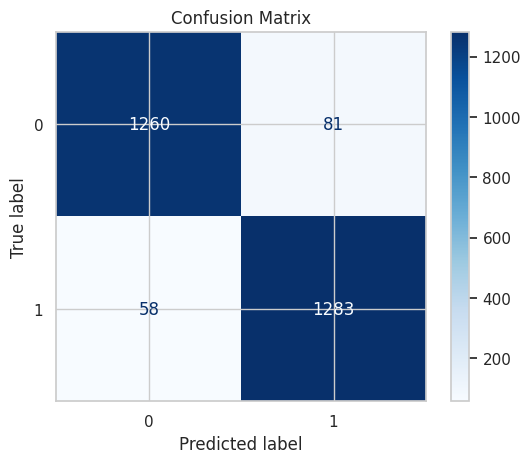

In [ ]:
xg2 = xgb.XGBClassifier(random_state = 786)
xg2.fit(X_train_trans, y_train_res)

train_pred = xg2.predict(X_train_trans)
print_metrics(y_train_res, train_pred)

Accuracy: 0.728
-------
F1 Score: 0.4
-------
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       288
           1       0.41      0.39      0.40        87

    accuracy                           0.73       375
   macro avg       0.61      0.61      0.61       375
weighted avg       0.72      0.73      0.73       375

-------
Confusion matrix (visualized below):


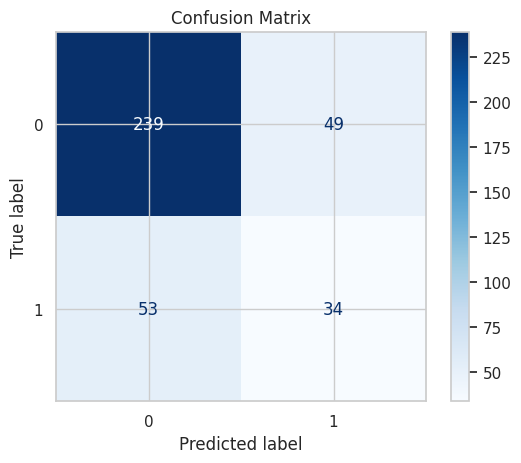

In [ ]:
#Validate
y_pred = xg2.predict(X_val_trans)
print_metrics(y_val, y_pred)

As expected, not good results.

#### Hyperparameter Tuning Using Random Search

In [ ]:
param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
}

cv = StratifiedKFold(n_splits=5)
scorer = make_scorer(f1_score, pos_label=1)

rand_xg2 = RandomizedSearchCV(
    estimator=xg2,
    param_distributions=param_distributions,
    n_iter=50,
    scoring=scorer,
    cv=cv,
    verbose=2,
    random_state=786,
    n_jobs=-1
)

rand_xg2.fit(X_train_trans, y_train_res)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           impor...
                                           num_parallel_tree=None,
                                           random_state=786, ...),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': [50, 100, 200, 300],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=786,
                   scoring=make_scorer(f1_score, response_method='predict', pos_label=1),
                   verbose=2)

In [ ]:
# View best score and parameters
print('Best score:', rand_xg2.best_score_)
print('Best params:', rand_xg2.best_params_)

Best score: 0.7541799968528919
Best params: {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}


#### Evaluating Random Search Results

In [ ]:
#evaluating full random search result
results_df = pd.DataFrame(rand_xg2.cv_results_)
display(results_df[['param_n_estimators', 'param_max_depth', 'param_learning_rate', 'param_subsample', 'param_colsample_bytree', 'param_gamma', 'mean_test_score', 'std_test_score']].sort_values(by='mean_test_score', ascending=False))

,param_n_estimators,param_max_depth,param_learning_rate,param_subsample,param_colsample_bytree,param_gamma,mean_test_score,std_test_score
39,300,5,0.010,0.600,1.000,0.000,0.754,0.141
34,100,10,0.100,0.800,0.800,0.100,0.751,0.157
19,200,5,0.050,0.800,1.000,0.100,0.751,0.159
15,200,5,0.200,1.000,0.800,0.100,0.750,0.150
1,50,5,0.050,0.800,0.800,0.300,0.750,0.145
4,50,5,0.050,0.600,0.800,0.100,0.750,0.146
16,100,7,0.200,0.600,0.600,0.000,0.750,0.156
45,300,5,0.200,0.800,0.600,0.300,0.750,0.151
0,300,10,0.010,0.600,0.800,0.000,0.750,0.160
37,50,5,0.050,0.800,0.800,0.000,0.749,0.141


- Using the logic explained before, the good row of parameters is row 33 which has descent mean score of 0.749 with relatively low standard deviation of 0.136.
- I will fit the model with this parameters.

Accuracy: 0.7333333333333333
-------
F1 Score: 0.3902439024390244
-------
Classification report:
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       288
           1       0.42      0.37      0.39        87

    accuracy                           0.73       375
   macro avg       0.62      0.61      0.61       375
weighted avg       0.72      0.73      0.73       375

-------
Confusion matrix (visualized below):


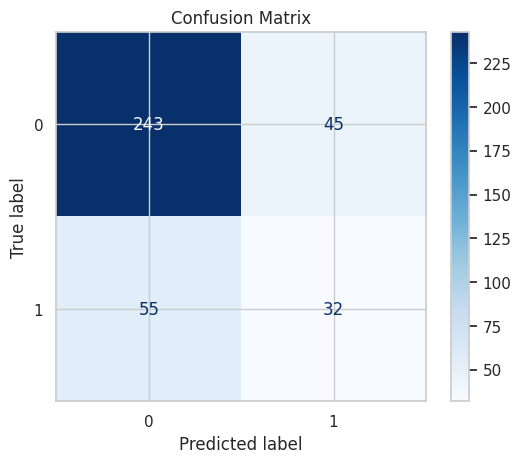

In [ ]:
#create xgb model using the above chose hyperparameters
xgb_model_22 = xgb.XGBClassifier(
    n_estimators=50,
    max_depth=7,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    objective='binary:logistic',
    random_state=786
)

xgb_model_22.fit(X_train_trans, y_train_res)
y_pred = xgb_model_22.predict(X_val_trans)
print_metrics(y_val, y_pred)

- As usual, no luck with the random search and processed data.
- The results became more worse.
- I will not be doing any manual tuning because I do not have any hope of getting better results.

In [ ]:
#saving the results
store_model_results('XGB_2', 0.42, 0.37, 0.39, model_results)
#Confirming the results
model_results

{'Log_reg_1': {'Precision': 0.39, 'Recall': 0.39, 'F1 Score': 0.39},
 'Log_reg_2': {'Precision': 0.33, 'Recall': 0.46, 'F1 Score': 0.38},
 'Log_reg_3': {'Precision': 0.36, 'Recall': 0.6, 'F1 Score': 0.45},
 'D_Tree_1': {'Precision': 0.45, 'Recall': 0.54, 'F1 Score': 0.49},
 'D_Tree_2': {'Precision': 0.36, 'Recall': 0.43, 'F1 Score': 0.39},
 'Rand_Forest_1': {'Precision': 0.4, 'Recall': 0.6, 'F1 Score': 0.48},
 'Rand_Forest_2': {'Precision': 0.41, 'Recall': 0.38, 'F1 Score': 0.4},
 'Rand_Forest_3': {'Precision': 0.45, 'Recall': 0.29, 'F1 Score': 0.35},
 'XGB_1': {'Precision': 0.45, 'Recall': 0.56, 'F1 Score': 0.5},
 'XGB_2': {'Precision': 0.42, 'Recall': 0.37, 'F1 Score': 0.39}}

## Model Interpretation & Selection

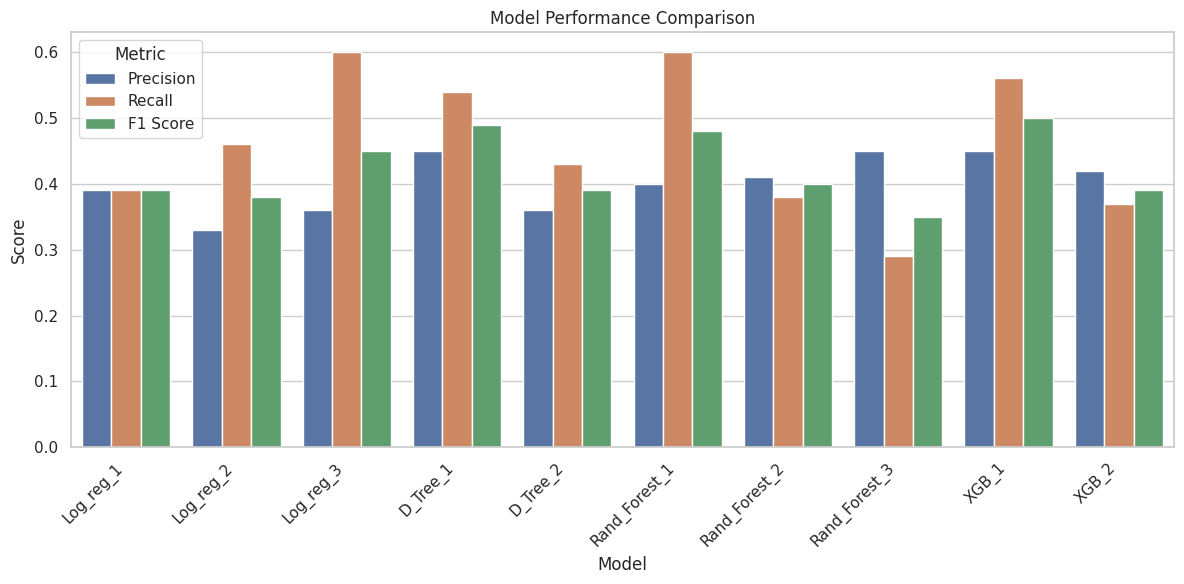

In [ ]:
# Create a DataFrame from the model results
results_df = pd.DataFrame(model_results).T.reset_index()
results_df = results_df.rename(columns={'index': 'Model'})
melted_df = pd.melt(results_df, id_vars='Model', var_name='Metric', value_name='Score')

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Score', hue='Metric', data=melted_df)
plt.xticks(rotation=45, ha='right')
plt.title('Model Performance Comparison')
plt.tight_layout()
plt.show()

### Interpretation

Just a reminder, my priority throughout the project was to make model predict the minority which was ad clicked as high as possible. The reason of it I have explained in the evaluation criteria section on top.

The models that used clas weight to handle class imbalance performed worse, which are:
- Log_reg_3
- Rand_Forest_3

This followed by the models that used trnasformed data, which are:
- Log_reg_2
- D_Tree_2
- Random_Forest_2
- XGB_2

The models that used only oversampled data gave the overall best results. At the beginning, I assumed that transforming the data will not have any effect on models like decision tree ot random forest but I was wrong.

Transformed data negatively impacted all models performance. However, the models that used just oversamples data, 2 of the models gave relatively better results compared to others.

This 2 models that gave almost similar results are:

**Decision Tree**
- F1 Score = 0.49
- Recall = 0.54
- Precision = 0.45

**XG-Boost**
- F1 Score = 0.50
- Recall = 0.56
- Precision = 0.45

These are 2 completely differnet models but it provides almost similar results on the data.

At the end, I have decided to go with Xg-Boost as my model with which I will evaluate my test data and the reasons why I chose Xg-Boost over Decision Tree is in the following section.


### Why XG-Boost?

**Decision Tree**
- The only advantage Decision tree (D.T) has over XGB is its simplicity. They are straight forward, relying on a sequence of binary splits to partition the data into homogenous groups.

- However, D.T tend to overfit if not properly tuned and that too especially with high dimensional dataset such as the one I am using.
- D.T also usually struggles with the complex, non-linear relationships or interaction between features.

**XG-Boost**
- On the other side, there are multiple positives of using XGB , especially with my dataset.

- It works by iteratively improving predictions through weak learners. Each successive tree focuses on correcting the errors made by previous trees, improving overall accuracy.
- It is also very good in Capturing complex patterns and interactions among features that a single decision tree might miss.
- The dataset that I used includes numerous weakly correlated features and interactions that XGBoost is better equipped to exploit.
- In future, If additional data or features are introduced, XGBoost can adapt more effectively than a single decision tree.
- The only con which I can think of is that performance depends heavily on tuning parameters like learning_rate, max_depth, and n_estimators but with the multiple benefits it provides, I am happy with tuning the model.

So, above are the reasons why I chose XGB over D.T.

In the next section, I will explain the results that we obtained from XGB and what it means.

### XG-Boost Results Evaluation

In [ ]:
model_results['XGB_1']

{'Precision': 0.45, 'Recall': 0.56, 'F1 Score': 0.5}

**Recall Consideration**
- Recall measures the ability of a model to identify all relevant instances in a dataset. In this context, it indicates how well the model can identify actual ad clicks.
- High recall means that the model is good at detecting most of the ad clicks, even if it sometimes incorrectly labels non-clicks as clicks (false positives).

**Precision Consideration**
- Precision measures the accuracy of the positive predictions. In this case, it indicates how many of the predicted ad clicks were actually clicks
- XGB_1 has a lower precision (0.45), meaning that out of all the predicted ad clicks, only 45% were correct. This indicates some false positives, but my priority is on recall, this trade-off is acceptable for me.

**Why XGB_1 is the Best Choice**

1) Highest Recall Score (0.56):

- XGB_1 has the second highest recall score among all the models. This means it successfully identifies 56% of the actual ad clicks.
- In simple term, when my model says that this customer will click the ad, there is 56% chance that the customer will click the ad.
- Since my priority is to capture as many ad clicks as possible, a high recall is crucial. Missing an ad click (false negative) is more costly than incorrectly predicting a click (false positive).

2) Balanced F1 Score (0.50)

- The F1 score is the harmonic mean of precision and recall, providing a single metric that balances both.
- XGB_1 F1 score is the highest, indicating it maintains a good balance between precision and recall. This balance is important because it shows the model is not only good at identifying ad clicks but also maintains a reasonable level of precision.

**Conclusion**
- The lower precision is a trade-off I am willing to accept because the cost of missing an actual ad click (false negative) is higher than the cost of incorrectly predicting a click (false positive).
---

### Evaluating Test Data

Accuracy: 0.6861702127659575
-------
F1 Score: 0.4326923076923077
-------
Classification report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       288
           1       0.38      0.51      0.43        88

    accuracy                           0.69       376
   macro avg       0.60      0.63      0.61       376
weighted avg       0.73      0.69      0.70       376

-------
Confusion matrix (visualized below):


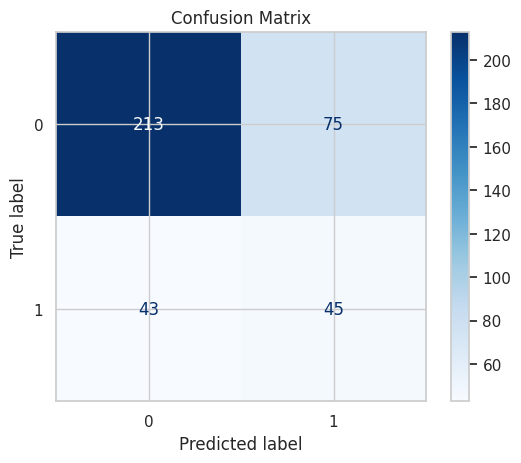

In [ ]:
# View metrics for Test data
y_pred_test = xgb_best.predict(X_test)
print_metrics(y_test, y_pred_test)

- The results are slightly lower than what it produced in the validation data.
- However, as I have discussed above the reasons for selcting XGB, in future with more bigger data set there is very high chance of it producing descent results and will also be able to generealise.
- In the end, I will not say that I was expecting this results but I am satisfied with my work and all the different approaches I have tried in the hopes of making it perform as best as I could.
- As I have mentioned in the introduction that I wanted to try out LSTM too but due to lack of time I will just briefly explain what I intended to do in the future work section.

### Recommendation

**Here are few recommendation on businesses can use the model to leverage on ad click prediction**

1) **Targeted Advertising Campaigns**
- **Personalized Ads**: Use the model to predict which users are likely to click on ads. Tailor ad content to these users to increase engagement and conversion rates
- **Ad Placement**: Optimize the placement of ads on websites or apps based on the predicted likelihood of clicks, ensuring ads are shown to the most responsive audience.

2) **Budget Allocation**
- **Efficient Spending**: Allocate advertising budgets more effectively by focusing on users who are predicted to click on ads. This can reduce wasted spend on less responsive segments.
- **Campaign Optimization**: Continuously monitor and adjust campaigns based on model predictions to maximize return on investment (ROI).

3) **Customer Retargeting**
- **Retargeting Campaigns**: Use the model to identify users who have previously shown interest in ads but did not convert. Retarget these users with follow-up ads to encourage conversion.
- **Dynamic Retargeting**: Implement dynamic retargeting by showing personalized ads based on users’ past interactions and predicted interests.

### Future Work

In future research, Long Short-Term Memory (LSTM) models could be explored to further improve predictions, particularly for the minority class. Key considerations include:

- **Sequential Patterns**: Utilize LSTM to capture temporal dependencies in features like `total_click`, `attention`, and `avg_xpos`.
- **Improved Minority Performance**: Leverage LSTM's ability to uncover subtle patterns in user interactions for better `Recall` and `F1 Score`.
- **Feature Encoding**: Transform features into time-series sequences for richer representations.
- **Handling Imbalanced Data**: Use oversampling (e.g., SMOTE-NC) or weighted loss functions with LSTM for better class balance.
- **Attention Mechanisms**: Integrate attention layers to highlight relevant features or time steps.
- **End-to-End Learning**: Frame the problem as a sequence-to-label task to simplify feature engineering.
- **Comparative Analysis**: Evaluate LSTM results against current models like XGBoost and decision trees.
- **Hybrid Approaches**: Combine LSTM outputs with existing models for enhanced predictive power.
